In [ ]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)

In [ ]:
!pip install einops -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.2 MB/s eta 0:00:00


In [ ]:
import einops
from einops import rearrange, reduce, repeat
from skimage import data
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class MyViT(nn.Module):
  def __init__(self):
    # Super constructor
    super(MyViT, self).__init__()

  def forward(self, images):
    pass

![ViT architecture](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*tA7xE2dQA_dfzA0Bub5TVw.png)

*`The architecture of the ViT with specific details on the transformer encoder and the MSA block. Keep this picture in mind. Picture from Bazi et. al.`*


# Let’s build the ViT in 6 main steps.

Step 1: Patchifying and the linear mapping

In [ ]:
# def patchify(images, n_patches):
#     n, c, h, w = images.shape

#     assert h == w, "Patchify method is implemented for square images only"

#     patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
#     patch_size = h // n_patches

#     for idx, image in enumerate(images):
#         for i in range(n_patches):
#             for j in range(n_patches):
#                 patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
#                 patches[idx, i * n_patches + j] = patch.flatten()
#     return patches

In [ ]:
# import torch

# def patchify(images, n_patches):
#     n, c, h, w = images.shape

#     assert h == w, "Patchify method is implemented for square images only"

#     patch_size = h // n_patches
#     patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
#     patches = patches.contiguous().view(n, -1, c * patch_size * patch_size)

#     return patches

In [ ]:


# def patchify(images, n_pathces):
#     """
#     Example:

#         x = torch.randn(1,1, 28,28)
#         rearrange(x, 'b c (h p1) (w p2) ->b p1 p2 c h w', p1=7, p2=7).shape

#         #Result: torch.Size([1, 7, 7, 1, 4, 4])

#         # We got 1 7x7 patched image totalling 49 patches, and each of the holding 4x4x1 (HxWxC) pixels.

#     """
#     b, c, h, w = images.shape
#     assert h == w, "Patchify method is implemented for square images only"
#     p1 = p2 = n_pathces

#     return rearrange(x, 'b c (h p1) (w p2) ->b (p1 p2 c) (h w)', p1=p1, p2=p2)


In [ ]:
import torch
from einops import rearrange

def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patch_size = h // n_patches

    # Rearrange the tensor to create patches directly
    patches = rearrange(images, 'n c (i p1) (j p2) -> n (i j) (c p1 p2)', i=n_patches, j=n_patches, p1=patch_size, p2=patch_size)

    return patches

In [ ]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7):
    # Super constructor
    super(MyViT, self).__init__()
    super().__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"

  def forward(self, images):
    patches = patchify(images, self.n_patches)
    return patches

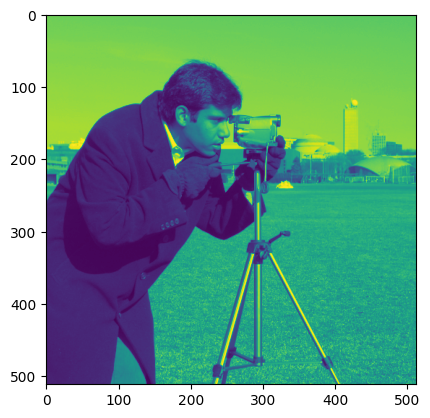

In [ ]:
camera = data.camera()
plt.imshow(camera)

In [ ]:
camera.shape

(512, 512)

In [ ]:
I =Image.fromarray(camera).convert('L')

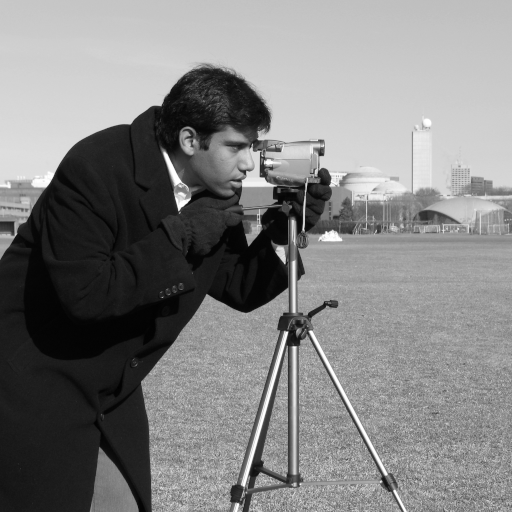

In [ ]:
I

In [ ]:
x = np.expand_dims(np.array(I), axis=(0,1))
x = torch.tensor(x,dtype=torch.float16)

In [ ]:
x.shape

torch.Size([1, 1, 512, 512])

In [ ]:
if __name__ == '__main__':
  # Current model
  model = MyViT(
    chw=(1, 512, 512),
    n_patches=8
  )

#   x = torch.randn(7, 1, 28, 28) # Dummy images
  print(model(x).shape) # torch.Size([7, 49, 16])

torch.Size([1, 64, 4096])


In [ ]:
patches = model(x)

In [ ]:
patches[0].shape

torch.Size([64, 4096])

In [ ]:
p1 = patches[0][0]

In [ ]:
p1.shape[0]


4096

In [ ]:
p1

tensor([200., 200., 200.,  ..., 207., 206., 206.], dtype=torch.float16)

In [ ]:
v = int(np.sqrt(p1.shape[0]))

In [ ]:
v

64

In [ ]:
p1 = p1.view(v,v)

In [ ]:
p1

tensor([[200., 200., 200.,  ..., 197., 197., 197.],
        [200., 199., 199.,  ..., 197., 198., 197.],
        [199., 199., 199.,  ..., 198., 198., 198.],
        ...,
        [207., 207., 207.,  ..., 207., 206., 206.],
        [207., 207., 206.,  ..., 207., 207., 206.],
        [207., 208., 208.,  ..., 207., 206., 206.]], dtype=torch.float16)

In [ ]:
x1 = x[0][0]
x1 = np.uint8(x1.numpy())

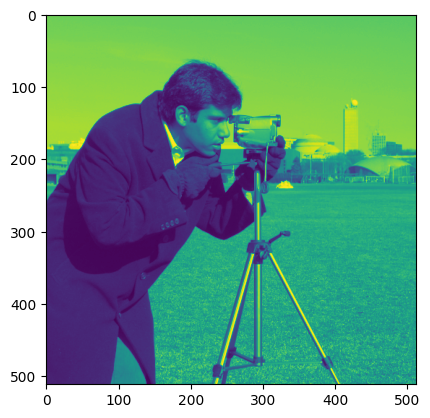

In [ ]:
plt.imshow(x1)

In [ ]:
p1 = np.uint8(p1.numpy())

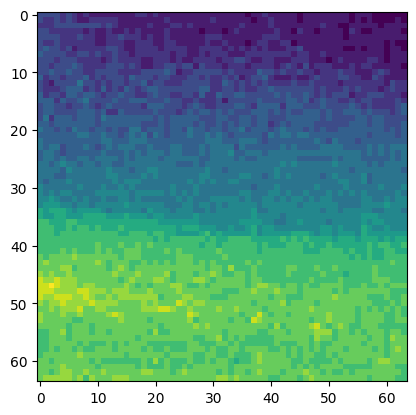

In [ ]:
plt.imshow(p1)

In [ ]:
patches.shape

torch.Size([1, 64, 4096])

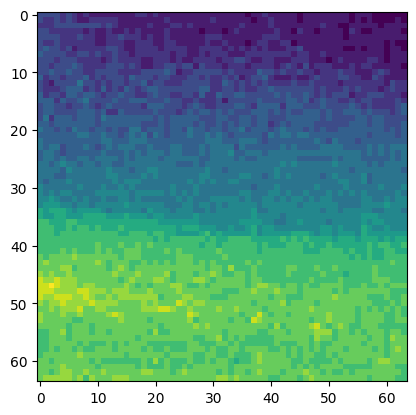

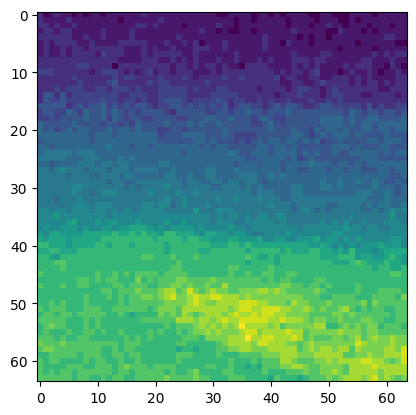

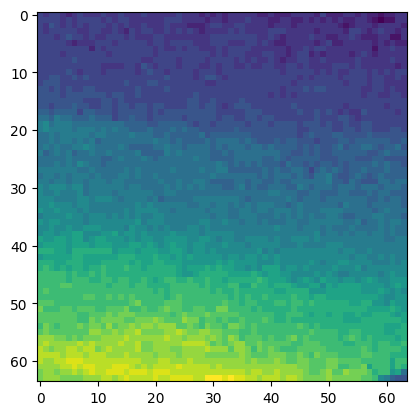

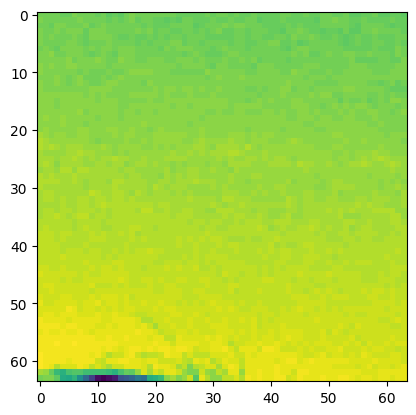

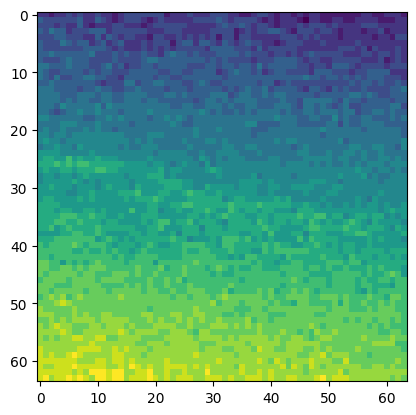

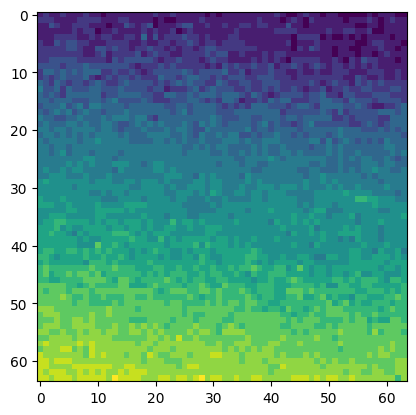

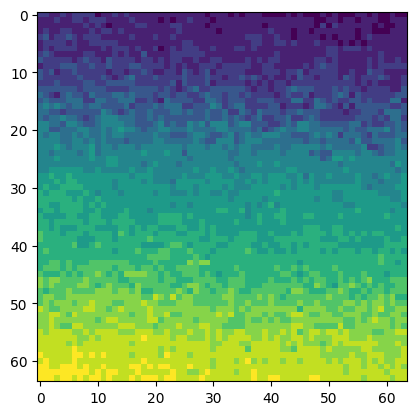

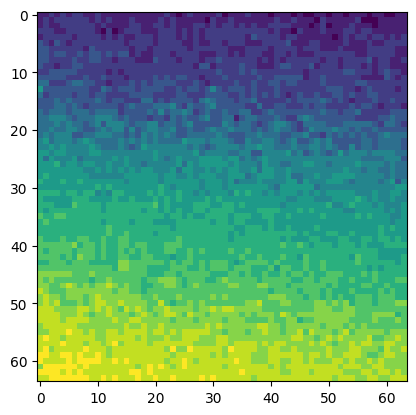

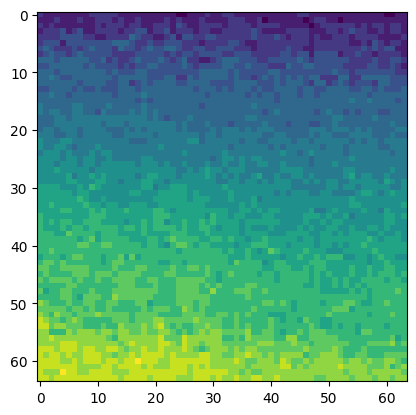

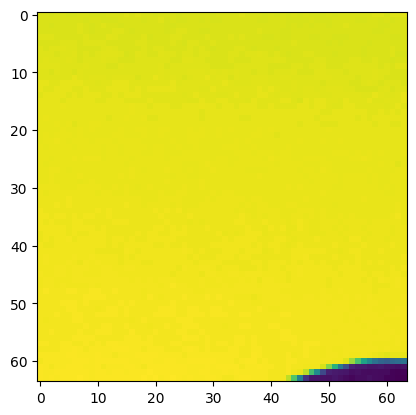

In [ ]:
for i in patches[0][:10]:
    p1 = i
    p1 = p1.view(v,v)
    p1 = np.uint8(p1.numpy())
    plt.imshow(p1)
    plt.show()

![link text](https://miro.medium.com/v2/resize:fit:640/format:webp/1*CFbOxEuvo-Pgq7ETIrt0Eg.png)
Raffiguration of how an image is split into patches. The 1x28x28 image is split into 49 (7x7) patches, each of size 16 (4x4x1)


$(N, PXP, (HXC/P) X (WXC/P)) = (N, 7X7, 4X4) = (N, 49, 16)$

Step 2: Adding the classification token

In [ ]:

    # 2) Learnable classifiation token
    # self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

In [ ]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7, hidden_d=100):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches
    self.hidden_d = hidden_d

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Linear mapper
    self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
    print(f"Linear in_channels -> out_channels: {(self.input_d, self.hidden_d)}")
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

    # 2) Learnable classifiation token
    self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

  def forward(self, images):
    print(f"Images size: {images.shape}")
    patches = patchify(images, self.n_patches)
    print(f"patches shape: {patches.shape}")
    tokens = self.linear_mapper(patches)

    print(f"tokens.shape: {tokens.shape}")

    print(f"tokens, class_token.shape: {tokens.shape} , {self.class_token.shape}" )
    # Adding classification token to the tokens
    tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])
    print(f"tokens.shape after stacking: {tokens.shape}")
    return tokens

In [ ]:
x.dtype

torch.float16

In [ ]:
if __name__ == '__main__':
  # Current model
  model = MyViT(
    chw=(1, 28, 28),
    n_patches=7,
    hidden_d=100
  )

  x = torch.randn(1, 1, 28, 28) # Dummy images
  print(model(x).shape) # torch.Size([7, 49, 16])

Linear in_channels -> out_channels: (16, 100)
Images size: torch.Size([1, 1, 28, 28])
patches shape: torch.Size([1, 49, 16])
tokens.shape: torch.Size([1, 49, 100])
tokens, class_token.shape: torch.Size([1, 49, 100]) , torch.Size([1, 100])
tokens.shape after stacking: torch.Size([1, 50, 100])
torch.Size([1, 50, 100])


In [ ]:
x = np.expand_dims(np.array(I), axis=(0,1))
x = torch.tensor(x,dtype=torch.float32)
chw = tuple(x.shape[1:])

In [ ]:
if __name__ == '__main__':
  # Current model
  model = MyViT(
    chw=chw,
    n_patches=8,
    hidden_d=100
  )

#   x = torch.randn(1, 1, 28, 28) # Dummy images
  print(model(x).shape) # torch.Size([7, 49, 16])

Linear in_channels -> out_channels: (4096, 100)
Images size: torch.Size([1, 1, 512, 512])
patches shape: torch.Size([1, 64, 4096])
tokens.shape: torch.Size([1, 64, 100])
tokens, class_token.shape: torch.Size([1, 64, 100]) , torch.Size([1, 100])
tokens.shape after stacking: torch.Size([1, 65, 100])
torch.Size([1, 65, 100])


Step 3: Positional encoding

![link text](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*lpRYHE0XjVkxRVKFrWkzuw.png)

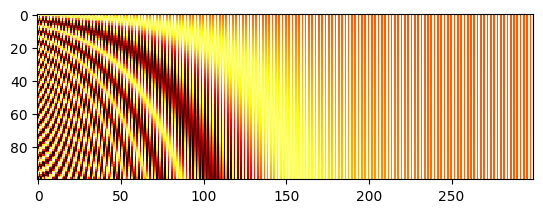

In [ ]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

if __name__ == "__main__":
  import matplotlib.pyplot as plt

  plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
  plt.show()

In [ ]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7, hidden_d=100):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches
    self.hidden_d = hidden_d

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Linear mapper
    self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

    # 2) Learnable classifiation token
    self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

    # 3) Positional embedding
    self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d)))
    self.pos_embed.requires_grad = False

  def forward(self, images):
    b,c,h,w = images.shape
    patches = patchify(images, self.n_patches)
    tokens = self.linear_mapper(patches)
    self.tokens = tokens

    # Adding classification token to the tokens
    tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])
    print(tokens)

    # Adding positional embedding
    pos_embed = self.pos_embed.repeat(b, 1, 1)
    out = tokens + pos_embed
    return out

In [ ]:
if __name__ == '__main__':
  # Current model
  model = MyViT(
    chw=(1, 28, 28),
    n_patches=7,
    hidden_d=100
  )

  x = torch.randn(7, 1, 28, 28) # Dummy images
  print(model(x).shape) # torch.Size([7, 49, 16]) -> torch.Size([7, 50, 100])

tensor([[[ 0.0567,  0.3538,  0.3751,  ...,  0.3836,  0.8831,  0.3820],
         [-0.4206, -1.1345, -0.9566,  ...,  1.2792, -0.9446, -1.5588],
         [ 0.3394, -0.3050,  0.2925,  ..., -1.0305,  0.7470, -0.2043],
         ...,
         [ 0.2837,  0.7263, -0.0056,  ..., -0.6199, -0.0826,  0.0966],
         [ 0.4968, -0.9543, -0.1912,  ..., -0.1745,  1.2203,  0.3920],
         [ 0.4562, -0.2118,  0.3233,  ..., -0.0331,  0.1752,  0.1563]],

        [[ 0.0567,  0.3538,  0.3751,  ...,  0.3836,  0.8831,  0.3820],
         [-0.2076, -0.4140, -0.0968,  ...,  0.4487, -0.1237, -0.0889],
         [-0.0983, -0.3425, -0.6027,  ...,  0.5330, -0.8655, -1.0897],
         ...,
         [-1.2499, -0.1821, -0.2639,  ...,  0.5471, -0.1414, -0.8286],
         [ 0.8762, -0.2727,  0.7448,  ...,  0.0486,  0.1018, -0.7499],
         [-1.2238, -0.8058, -0.0389,  ..., -0.8184,  1.2906,  0.1112]],

        [[ 0.0567,  0.3538,  0.3751,  ...,  0.3836,  0.8831,  0.3820],
         [-0.4395, -0.8526, -1.2726,  ..., -0

<ipython-input-80-1b6b83f16916>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d)))


In [ ]:
class_token = model.class_token

In [ ]:
class_token

Parameter containing:
tensor([[0.0567, 0.3538, 0.3751, 0.8041, 0.1638, 0.3131, 0.6500, 0.7941, 0.0819,
         0.4417, 0.7073, 0.7428, 0.4482, 0.5477, 0.3784, 0.4641, 0.4304, 0.2180,
         0.5472, 0.5035, 0.4304, 0.0164, 0.9239, 0.6186, 0.1982, 0.3700, 0.0821,
         0.4117, 0.0860, 0.3834, 0.2798, 0.9091, 0.8367, 0.6374, 0.6260, 0.2371,
         0.2930, 0.4248, 0.3891, 0.6594, 0.1644, 0.6287, 0.5736, 0.0189, 0.2794,
         0.0294, 0.2697, 0.0455, 0.4324, 0.1088, 0.9617, 0.9796, 0.3623, 0.6041,
         0.7847, 0.5660, 0.5816, 0.7471, 0.4862, 0.2845, 0.9961, 0.8954, 0.4523,
         0.7375, 0.8018, 0.1380, 0.9462, 0.1377, 0.2001, 0.8681, 0.2721, 0.5068,
         0.7223, 0.2068, 0.1716, 0.7032, 0.1082, 0.3046, 0.1059, 0.6929, 0.0572,
         0.6273, 0.4284, 0.4532, 0.3623, 0.1420, 0.9287, 0.1327, 0.2459, 0.0401,
         0.1208, 0.4392, 0.3618, 0.7754, 0.4182, 0.8240, 0.8701, 0.3836, 0.8831,
         0.3820]], requires_grad=True)

In [ ]:
tokens = model.tokens

In [ ]:
print(class_token.shape, tokens.shape)

torch.Size([1, 100]) torch.Size([7, 49, 100])


In [ ]:
expanded_class_token = class_token.unsqueeze(1).expand(tokens.shape[0], -1, -1)

In [ ]:
expanded_class_token.shape

torch.Size([7, 1, 100])

In [ ]:
tokens.shape

torch.Size([7, 49, 100])

In [ ]:
# Concatenating the 'class_token' with 'tokens' along the second dimension (rows)
tokens_with_class = torch.cat((expanded_class_token, tokens), dim=1)
tokens_with_class.shape

torch.Size([7, 50, 100])

In [ ]:
tokens_with_class

tensor([[[ 0.0567,  0.3538,  0.3751,  ...,  0.3836,  0.8831,  0.3820],
         [-0.4206, -1.1345, -0.9566,  ...,  1.2792, -0.9446, -1.5588],
         [ 0.3394, -0.3050,  0.2925,  ..., -1.0305,  0.7470, -0.2043],
         ...,
         [ 0.2837,  0.7263, -0.0056,  ..., -0.6199, -0.0826,  0.0966],
         [ 0.4968, -0.9543, -0.1912,  ..., -0.1745,  1.2203,  0.3920],
         [ 0.4562, -0.2118,  0.3233,  ..., -0.0331,  0.1752,  0.1563]],

        [[ 0.0567,  0.3538,  0.3751,  ...,  0.3836,  0.8831,  0.3820],
         [-0.2076, -0.4140, -0.0968,  ...,  0.4487, -0.1237, -0.0889],
         [-0.0983, -0.3425, -0.6027,  ...,  0.5330, -0.8655, -1.0897],
         ...,
         [-1.2499, -0.1821, -0.2639,  ...,  0.5471, -0.1414, -0.8286],
         [ 0.8762, -0.2727,  0.7448,  ...,  0.0486,  0.1018, -0.7499],
         [-1.2238, -0.8058, -0.0389,  ..., -0.8184,  1.2906,  0.1112]],

        [[ 0.0567,  0.3538,  0.3751,  ...,  0.3836,  0.8831,  0.3820],
         [-0.4395, -0.8526, -1.2726,  ..., -0

In [ ]:
x = np.expand_dims(np.array(I), axis=(0,1))
x = torch.tensor(x,dtype=torch.float32)
chw = tuple(x.shape[1:])
if __name__ == '__main__':
  # Current model
  model = MyViT(
    chw=chw,
    n_patches=8,
    hidden_d=100
  )

#   x = torch.randn(7, 1, 28, 28) # Dummy images
  print(model(x).shape) # torch.Size([7, 49, 16]) -> torch.Size([7, 50, 100])

tensor([[[ 7.4533e-02,  5.8534e-01,  1.6987e-01,  ...,  5.3304e-01,
           8.3338e-01,  2.9710e-01],
         [ 1.9144e+02,  1.3377e+02, -1.0966e+02,  ..., -1.5959e+01,
          -1.0933e+02,  2.8863e+01],
         [ 1.9088e+02,  1.3334e+02, -1.0842e+02,  ..., -1.5199e+01,
          -1.0972e+02,  2.9481e+01],
         ...,
         [ 1.4087e+02,  1.0184e+02, -9.3624e+01,  ..., -4.9289e+00,
          -7.7580e+01,  2.0480e+01],
         [ 1.0858e+02,  1.1846e+02, -6.3371e+01,  ..., -3.8788e+01,
          -9.8051e+01,  5.4648e+01],
         [ 1.0970e+02,  1.1641e+02, -7.6788e+01,  ..., -1.7294e+01,
          -9.2981e+01,  2.8102e+01]]], grad_fn=<StackBackward0>)
torch.Size([1, 65, 100])


<ipython-input-80-1b6b83f16916>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d)))


Step 4: The encoder block (Part 1/2)


In [ ]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [ ]:
import torch
import torch.nn as nn

class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.qkv_mapping = nn.Linear(d, d * 3)
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # Calculate q, k, v using a single linear mapping

        N, seq_length, _ = sequences.size()
        d_head = self.d_head
        n_heads = self.n_heads

        qkv = self.qkv_mapping(sequences).view(N, seq_length, n_heads, 3 * d_head)
        q, k, v = torch.split(qkv, d_head, dim=-1)

        attention = torch.einsum("nshd,nthd->nst", q, k) / (d_head ** 0.5)
        attention = self.softmax(attention)
        result = torch.einsum("nst,nshd->nthd", attention, v).view(N, seq_length, -1)

        return result


In [ ]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        return out

In [ ]:
if __name__ == '__main__':
  model = MyViTBlock(hidden_d=8, n_heads=2)

  x = torch.randn(7, 50, 8)  # Dummy sequences
  print(model(x).shape)      # torch.Size([7, 50, 8])

torch.Size([7, 50, 8])


Step 5: The encoder block (Part 2/2)

In [ ]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [ ]:
if __name__ == '__main__':
  model = MyViTBlock(hidden_d=8, n_heads=2)

  x = torch.randn(7, 50, 8)  # Dummy sequences
  print(model(x).shape)      # torch.Size([7, 50, 8])

torch.Size([7, 50, 8])


In [ ]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        return out

In [ ]:
if __name__ == '__main__':
  # Current model
  model = MyViT(
    chw=(1, 28, 28),
    n_patches=7,
    hidden_d=8
  )

  x = torch.randn(7, 1, 28, 28) # Dummy images
  print(model(x).shape) # torch.Size([7, 50, 8])

torch.Size([7, 50, 8])


Step 6: Classification MLP

In [ ]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

        # 5) Classification MLPk
        # bxhidden_d X hiden_dxout_d = bXout_d
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)
        # print(out.shape)
        # Getting the classification token only
        out = out[:, 0]
        # print(out.shape)
        return self.mlp(out) # Map to output dimension, output category distribution

In [ ]:
if __name__ == '__main__':
  # Current model
  model = MyViT(
    chw=(1, 28, 28),
    n_patches=7,
    hidden_d=8
  )

  x = torch.randn(7, 1, 28, 28) # Dummy images
  print(model(x).shape)

torch.Size([7, 50, 8])
torch.Size([7, 8])
torch.Size([7, 10])


In [ ]:
def main():
    # Loading data
    transform = ToTensor()

    train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)
    test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
    model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
    N_EPOCHS = 5
    LR = 0.005

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")

In [ ]:
main()

100%|██████████| 9912422/9912422 [00:00<00:00, 130551561.08it/s]


Extracting ./../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./../datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 9468164.28it/s]


Extracting ./../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./../datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29168053.80it/s]


Extracting ./../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./../datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5497988.10it/s]

Extracting ./../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./../datasets/MNIST/raw



Using device:  cpu 


Epoch 1 in training:   0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   0%|          | 1/469 [00:00<07:08,  1.09it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   1%|          | 3/469 [00:02<06:20,  1.22it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   1%|          | 5/469 [00:03<03:56,  1.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   1%|▏         | 6/469 [00:03<03:27,  2.24it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   1%|▏         | 7/469 [00:03<03:04,  2.50it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   2%|▏         | 8/469 [00:04<02:51,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   2%|▏         | 9/469 [00:04<02:39,  2.88it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   2%|▏         | 10/469 [00:04<02:35,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   2%|▏         | 11/469 [00:05<02:30,  3.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   3%|▎         | 12/469 [00:05<02:25,  3.14it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   3%|▎         | 13/469 [00:05<02:24,  3.15it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   3%|▎         | 14/469 [00:05<02:22,  3.18it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   3%|▎         | 15/469 [00:06<02:20,  3.23it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   3%|▎         | 16/469 [00:06<02:21,  3.20it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   4%|▎         | 17/469 [00:06<02:20,  3.22it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   4%|▍         | 18/469 [00:07<02:18,  3.26it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   4%|▍         | 19/469 [00:07<02:17,  3.27it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   4%|▍         | 20/469 [00:07<02:19,  3.22it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   5%|▍         | 22/469 [00:08<02:22,  3.13it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   5%|▍         | 23/469 [00:08<02:21,  3.15it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   5%|▌         | 24/469 [00:09<02:35,  2.86it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   5%|▌         | 25/469 [00:09<02:48,  2.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   6%|▌         | 26/469 [00:10<02:55,  2.52it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   6%|▌         | 27/469 [00:10<03:03,  2.41it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   6%|▌         | 28/469 [00:11<03:08,  2.34it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   6%|▋         | 30/469 [00:11<03:04,  2.38it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   7%|▋         | 31/469 [00:12<02:51,  2.56it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   7%|▋         | 32/469 [00:12<02:41,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   7%|▋         | 33/469 [00:12<02:36,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   7%|▋         | 34/469 [00:13<02:28,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   7%|▋         | 35/469 [00:13<02:23,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   8%|▊         | 36/469 [00:13<02:19,  3.10it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   8%|▊         | 37/469 [00:14<02:19,  3.09it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   8%|▊         | 38/469 [00:14<02:15,  3.17it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   8%|▊         | 39/469 [00:14<02:14,  3.21it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   9%|▊         | 40/469 [00:14<02:14,  3.20it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   9%|▊         | 41/469 [00:15<02:12,  3.22it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   9%|▉         | 42/469 [00:15<02:12,  3.23it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   9%|▉         | 43/469 [00:15<02:13,  3.20it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:   9%|▉         | 44/469 [00:16<02:13,  3.19it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  10%|▉         | 45/469 [00:16<02:11,  3.22it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  10%|▉         | 46/469 [00:16<02:10,  3.25it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  10%|█         | 47/469 [00:17<02:11,  3.21it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  10%|█         | 48/469 [00:17<02:11,  3.20it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  10%|█         | 49/469 [00:17<02:10,  3.21it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  11%|█         | 50/469 [00:18<02:11,  3.19it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  11%|█         | 51/469 [00:18<02:10,  3.20it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  11%|█         | 52/469 [00:18<02:09,  3.23it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  11%|█▏        | 53/469 [00:19<02:10,  3.20it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  12%|█▏        | 54/469 [00:19<02:08,  3.23it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  12%|█▏        | 56/469 [00:20<02:19,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  12%|█▏        | 57/469 [00:20<02:14,  3.06it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  12%|█▏        | 58/469 [00:20<02:11,  3.13it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  13%|█▎        | 59/469 [00:20<02:08,  3.20it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  13%|█▎        | 60/469 [00:21<02:09,  3.15it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  13%|█▎        | 61/469 [00:21<02:08,  3.18it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  13%|█▎        | 62/469 [00:22<02:28,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  13%|█▎        | 63/469 [00:22<02:40,  2.53it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  14%|█▎        | 64/469 [00:23<02:50,  2.38it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  14%|█▍        | 65/469 [00:23<02:56,  2.28it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  14%|█▍        | 67/469 [00:24<02:59,  2.24it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  15%|█▍        | 69/469 [00:25<02:35,  2.57it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  15%|█▍        | 70/469 [00:25<02:25,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  15%|█▌        | 71/469 [00:25<02:17,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  15%|█▌        | 72/469 [00:26<02:13,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  16%|█▌        | 73/469 [00:26<02:10,  3.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  16%|█▌        | 74/469 [00:26<02:08,  3.08it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  16%|█▌        | 75/469 [00:26<02:05,  3.15it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  16%|█▌        | 76/469 [00:27<02:04,  3.16it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  16%|█▋        | 77/469 [00:27<02:03,  3.17it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  17%|█▋        | 79/469 [00:28<02:05,  3.10it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  17%|█▋        | 80/469 [00:28<02:02,  3.16it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  17%|█▋        | 81/469 [00:28<02:01,  3.19it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  17%|█▋        | 82/469 [00:29<02:01,  3.19it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  18%|█▊        | 83/469 [00:29<02:00,  3.20it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  18%|█▊        | 84/469 [00:29<02:00,  3.19it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  18%|█▊        | 85/469 [00:30<02:01,  3.17it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  18%|█▊        | 86/469 [00:30<02:02,  3.13it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  19%|█▊        | 87/469 [00:30<02:00,  3.16it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  19%|█▉        | 88/469 [00:31<01:59,  3.18it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  19%|█▉        | 89/469 [00:31<01:58,  3.19it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  19%|█▉        | 90/469 [00:31<01:57,  3.22it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  19%|█▉        | 91/469 [00:32<01:57,  3.23it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  20%|█▉        | 92/469 [00:32<01:56,  3.24it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  20%|█▉        | 93/469 [00:32<01:56,  3.22it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  20%|██        | 94/469 [00:32<01:56,  3.22it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  20%|██        | 95/469 [00:33<01:55,  3.24it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  20%|██        | 96/469 [00:33<01:56,  3.19it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  21%|██        | 97/469 [00:33<01:55,  3.22it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  21%|██        | 98/469 [00:34<01:55,  3.23it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  21%|██        | 99/469 [00:34<02:16,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  21%|██▏       | 100/469 [00:35<02:28,  2.48it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  22%|██▏       | 101/469 [00:35<02:43,  2.25it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  22%|██▏       | 102/469 [00:36<02:44,  2.23it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  22%|██▏       | 104/469 [00:37<02:44,  2.22it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  22%|██▏       | 105/469 [00:37<02:27,  2.47it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  23%|██▎       | 106/469 [00:37<02:35,  2.34it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  23%|██▎       | 107/469 [00:38<02:23,  2.53it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  23%|██▎       | 108/469 [00:38<02:13,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  23%|██▎       | 109/469 [00:38<02:07,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  23%|██▎       | 110/469 [00:39<02:03,  2.91it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  24%|██▎       | 111/469 [00:39<01:58,  3.03it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  24%|██▍       | 112/469 [00:39<01:56,  3.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  24%|██▍       | 113/469 [00:40<01:55,  3.09it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  24%|██▍       | 114/469 [00:40<01:52,  3.14it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  25%|██▍       | 115/469 [00:40<01:52,  3.15it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  25%|██▍       | 116/469 [00:41<01:50,  3.19it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  25%|██▍       | 117/469 [00:41<01:49,  3.20it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  25%|██▌       | 118/469 [00:41<01:50,  3.19it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  25%|██▌       | 119/469 [00:41<01:50,  3.16it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  26%|██▌       | 120/469 [00:42<01:50,  3.16it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  26%|██▌       | 121/469 [00:42<01:50,  3.15it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  26%|██▌       | 122/469 [00:42<01:50,  3.15it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  26%|██▌       | 123/469 [00:43<01:48,  3.19it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  26%|██▋       | 124/469 [00:43<01:49,  3.15it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  27%|██▋       | 125/469 [00:43<01:49,  3.16it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  27%|██▋       | 126/469 [00:44<01:47,  3.19it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  27%|██▋       | 127/469 [00:44<01:46,  3.21it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  27%|██▋       | 128/469 [00:44<01:46,  3.20it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  28%|██▊       | 129/469 [00:45<01:46,  3.19it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  28%|██▊       | 130/469 [00:45<01:45,  3.21it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  28%|██▊       | 131/469 [00:45<01:46,  3.19it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  28%|██▊       | 132/469 [00:46<01:47,  3.14it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  28%|██▊       | 133/469 [00:46<01:45,  3.17it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  29%|██▊       | 134/469 [00:46<01:44,  3.21it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  29%|██▉       | 135/469 [00:47<01:47,  3.11it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])


torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  29%|██▉       | 136/469 [00:47<02:03,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  29%|██▉       | 137/469 [00:47<02:14,  2.48it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  29%|██▉       | 138/469 [00:48<02:18,  2.39it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  30%|██▉       | 139/469 [00:48<02:20,  2.35it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  30%|██▉       | 140/469 [00:49<02:25,  2.27it/s]


torch.Size([128, 50, 8])
torch.Size([128, 8])


Epoch 1 in training:  30%|███       | 141/469 [00:49<02:19,  2.35it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  30%|███       | 143/469 [00:50<02:02,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  31%|███       | 144/469 [00:50<01:54,  2.84it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  31%|███       | 145/469 [00:51<01:50,  2.93it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  31%|███       | 146/469 [00:51<01:47,  3.01it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  31%|███▏      | 147/469 [00:51<01:43,  3.10it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  32%|███▏      | 148/469 [00:51<01:42,  3.14it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  32%|███▏      | 149/469 [00:52<01:42,  3.12it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  32%|███▏      | 150/469 [00:52<01:40,  3.18it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  32%|███▏      | 151/469 [00:52<01:39,  3.19it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  32%|███▏      | 152/469 [00:53<01:38,  3.23it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  33%|███▎      | 153/469 [00:53<01:37,  3.25it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  33%|███▎      | 154/469 [00:53<01:36,  3.25it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  33%|███▎      | 155/469 [00:54<01:38,  3.18it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  33%|███▎      | 156/469 [00:54<01:38,  3.18it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  33%|███▎      | 157/469 [00:54<01:37,  3.21it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  34%|███▎      | 158/469 [00:55<01:37,  3.20it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  34%|███▍      | 159/469 [00:55<01:37,  3.16it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  34%|███▍      | 160/469 [00:55<01:37,  3.18it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  34%|███▍      | 161/469 [00:55<01:37,  3.16it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  35%|███▍      | 162/469 [00:56<01:36,  3.18it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  35%|███▍      | 163/469 [00:56<01:36,  3.16it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  35%|███▍      | 164/469 [00:56<01:35,  3.18it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  35%|███▌      | 165/469 [00:57<01:37,  3.13it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  35%|███▌      | 166/469 [00:57<01:35,  3.16it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  36%|███▌      | 167/469 [00:57<01:35,  3.16it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  36%|███▌      | 168/469 [00:58<01:39,  3.03it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  36%|███▌      | 169/469 [00:58<01:38,  3.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  36%|███▌      | 170/469 [00:58<01:37,  3.07it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  36%|███▋      | 171/469 [00:59<01:36,  3.08it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  37%|███▋      | 172/469 [00:59<01:35,  3.13it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  37%|███▋      | 173/469 [00:59<01:47,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  37%|███▋      | 174/469 [01:00<01:58,  2.49it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  37%|███▋      | 175/469 [01:00<02:02,  2.40it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  38%|███▊      | 176/469 [01:01<02:07,  2.30it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  38%|███▊      | 177/469 [01:01<02:10,  2.25it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  38%|███▊      | 179/469 [01:02<02:01,  2.38it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  38%|███▊      | 180/469 [01:03<01:52,  2.56it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  39%|███▊      | 181/469 [01:03<01:48,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  39%|███▉      | 182/469 [01:03<01:42,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  39%|███▉      | 183/469 [01:03<01:38,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  39%|███▉      | 184/469 [01:04<01:35,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  39%|███▉      | 185/469 [01:04<01:36,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  40%|███▉      | 186/469 [01:04<01:33,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  40%|███▉      | 187/469 [01:05<01:32,  3.03it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  40%|████      | 188/469 [01:05<01:33,  3.01it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  40%|████      | 189/469 [01:05<01:31,  3.06it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  41%|████      | 190/469 [01:06<01:31,  3.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  41%|████      | 191/469 [01:06<01:31,  3.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  41%|████      | 192/469 [01:06<01:31,  3.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  41%|████      | 193/469 [01:07<01:31,  3.00it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  41%|████▏     | 194/469 [01:07<01:31,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  42%|████▏     | 196/469 [01:08<01:31,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  42%|████▏     | 197/469 [01:08<01:30,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  42%|████▏     | 198/469 [01:08<01:30,  3.00it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  42%|████▏     | 199/469 [01:09<01:28,  3.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  43%|████▎     | 200/469 [01:09<01:28,  3.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  43%|████▎     | 201/469 [01:09<01:26,  3.09it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  43%|████▎     | 202/469 [01:10<01:26,  3.07it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  43%|████▎     | 203/469 [01:10<01:26,  3.09it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  43%|████▎     | 204/469 [01:10<01:24,  3.12it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  44%|████▎     | 205/469 [01:11<01:24,  3.11it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  44%|████▍     | 206/469 [01:11<01:24,  3.13it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  44%|████▍     | 207/469 [01:11<01:23,  3.13it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  44%|████▍     | 208/469 [01:12<01:22,  3.18it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  45%|████▍     | 209/469 [01:12<01:22,  3.17it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  45%|████▍     | 210/469 [01:12<01:34,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  45%|████▍     | 211/469 [01:13<01:40,  2.57it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  45%|████▌     | 212/469 [01:13<01:47,  2.39it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  45%|████▌     | 213/469 [01:14<01:50,  2.32it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  46%|████▌     | 214/469 [01:14<01:53,  2.25it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  46%|████▌     | 216/469 [01:15<01:45,  2.41it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  46%|████▋     | 217/469 [01:15<01:37,  2.59it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  46%|████▋     | 218/469 [01:16<01:31,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  47%|████▋     | 219/469 [01:16<01:40,  2.49it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  47%|████▋     | 220/469 [01:17<01:37,  2.55it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  47%|████▋     | 221/469 [01:17<01:42,  2.42it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  47%|████▋     | 222/469 [01:18<01:47,  2.30it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  48%|████▊     | 223/469 [01:18<01:47,  2.30it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  48%|████▊     | 224/469 [01:18<01:46,  2.30it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  48%|████▊     | 225/469 [01:19<01:49,  2.23it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  48%|████▊     | 227/469 [01:20<01:39,  2.44it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  49%|████▊     | 228/469 [01:20<01:31,  2.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  49%|████▉     | 229/469 [01:20<01:26,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  49%|████▉     | 230/469 [01:21<01:22,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  49%|████▉     | 231/469 [01:21<01:19,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  49%|████▉     | 232/469 [01:21<01:17,  3.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  50%|████▉     | 233/469 [01:22<01:16,  3.09it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  50%|████▉     | 234/469 [01:22<01:16,  3.08it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  50%|█████     | 235/469 [01:22<01:15,  3.11it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  50%|█████     | 236/469 [01:22<01:14,  3.14it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  51%|█████     | 237/469 [01:23<01:13,  3.14it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  51%|█████     | 238/469 [01:23<01:13,  3.15it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  51%|█████     | 239/469 [01:23<01:12,  3.17it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  51%|█████     | 240/469 [01:24<01:13,  3.14it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  51%|█████▏    | 241/469 [01:24<01:12,  3.15it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  52%|█████▏    | 242/469 [01:24<01:11,  3.16it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  52%|█████▏    | 243/469 [01:25<01:14,  3.03it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  52%|█████▏    | 244/469 [01:25<01:32,  2.44it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  52%|█████▏    | 245/469 [01:26<01:35,  2.34it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  52%|█████▏    | 246/469 [01:26<01:37,  2.28it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  53%|█████▎    | 247/469 [01:27<01:38,  2.25it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  53%|█████▎    | 249/469 [01:28<01:36,  2.28it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  53%|█████▎    | 250/469 [01:28<01:28,  2.49it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  54%|█████▎    | 251/469 [01:28<01:21,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  54%|█████▎    | 252/469 [01:29<01:17,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  54%|█████▍    | 253/469 [01:29<01:15,  2.88it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  54%|█████▍    | 254/469 [01:29<01:11,  3.00it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  54%|█████▍    | 255/469 [01:30<01:10,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  55%|█████▍    | 256/469 [01:30<01:10,  3.03it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  55%|█████▍    | 257/469 [01:30<01:08,  3.09it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  55%|█████▌    | 258/469 [01:30<01:07,  3.12it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  55%|█████▌    | 259/469 [01:31<01:07,  3.11it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  55%|█████▌    | 260/469 [01:31<01:07,  3.09it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  56%|█████▌    | 261/469 [01:31<01:06,  3.12it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  56%|█████▌    | 262/469 [01:32<01:07,  3.09it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  56%|█████▌    | 263/469 [01:32<01:06,  3.11it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  56%|█████▋    | 264/469 [01:32<01:05,  3.14it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  57%|█████▋    | 265/469 [01:33<01:05,  3.13it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  57%|█████▋    | 266/469 [01:33<01:04,  3.15it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  57%|█████▋    | 267/469 [01:33<01:04,  3.15it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  57%|█████▋    | 268/469 [01:34<01:03,  3.17it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  57%|█████▋    | 269/469 [01:34<01:05,  3.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  58%|█████▊    | 270/469 [01:34<01:04,  3.08it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  58%|█████▊    | 271/469 [01:35<01:03,  3.11it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  58%|█████▊    | 272/469 [01:35<01:03,  3.12it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  58%|█████▊    | 273/469 [01:35<01:02,  3.16it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  58%|█████▊    | 274/469 [01:36<01:01,  3.16it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  59%|█████▊    | 275/469 [01:36<01:01,  3.17it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  59%|█████▉    | 276/469 [01:36<01:01,  3.13it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  59%|█████▉    | 277/469 [01:37<01:01,  3.13it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  59%|█████▉    | 278/469 [01:37<01:01,  3.11it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  59%|█████▉    | 279/469 [01:37<01:01,  3.10it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  60%|█████▉    | 280/469 [01:38<01:03,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  60%|█████▉    | 281/469 [01:38<01:10,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  60%|██████    | 282/469 [01:38<01:14,  2.51it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  60%|██████    | 283/469 [01:39<01:17,  2.39it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  61%|██████    | 284/469 [01:39<01:21,  2.26it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  61%|██████    | 286/469 [01:40<01:20,  2.26it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  61%|██████    | 287/469 [01:41<01:13,  2.48it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  61%|██████▏   | 288/469 [01:41<01:07,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  62%|██████▏   | 289/469 [01:41<01:05,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  62%|██████▏   | 290/469 [01:42<01:02,  2.84it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  62%|██████▏   | 291/469 [01:42<01:00,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  62%|██████▏   | 293/469 [01:43<00:58,  3.01it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  63%|██████▎   | 294/469 [01:43<00:57,  3.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  63%|██████▎   | 295/469 [01:43<00:56,  3.10it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  63%|██████▎   | 296/469 [01:44<00:55,  3.09it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  64%|██████▎   | 298/469 [01:45<01:11,  2.40it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  64%|██████▍   | 299/469 [01:45<01:05,  2.58it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  64%|██████▍   | 300/469 [01:45<01:02,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  64%|██████▍   | 301/469 [01:46<00:59,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  64%|██████▍   | 302/469 [01:46<00:57,  2.90it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  65%|██████▍   | 303/469 [01:46<00:56,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  65%|██████▍   | 304/469 [01:47<00:55,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  65%|██████▌   | 305/469 [01:47<00:59,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  65%|██████▌   | 307/469 [01:48<01:10,  2.30it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  66%|██████▌   | 308/469 [01:48<01:04,  2.50it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  66%|██████▌   | 309/469 [01:49<00:59,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  66%|██████▌   | 310/469 [01:49<00:56,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  66%|██████▋   | 311/469 [01:49<00:54,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  67%|██████▋   | 312/469 [01:50<00:53,  2.91it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  67%|██████▋   | 313/469 [01:50<00:52,  3.00it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  67%|██████▋   | 314/469 [01:50<00:54,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  67%|██████▋   | 315/469 [01:51<00:59,  2.59it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  67%|██████▋   | 316/469 [01:51<01:02,  2.46it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  68%|██████▊   | 317/469 [01:52<01:03,  2.38it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  68%|██████▊   | 318/469 [01:52<01:10,  2.16it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  68%|██████▊   | 320/469 [01:53<01:04,  2.30it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  68%|██████▊   | 321/469 [01:54<00:59,  2.49it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  69%|██████▊   | 322/469 [01:54<00:55,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  69%|██████▉   | 323/469 [01:54<00:51,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  69%|██████▉   | 324/469 [01:54<00:50,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  69%|██████▉   | 325/469 [01:55<00:48,  2.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  70%|██████▉   | 327/469 [01:56<00:49,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  70%|██████▉   | 328/469 [01:56<00:47,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  70%|███████   | 329/469 [01:56<00:46,  3.00it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  70%|███████   | 330/469 [01:57<00:52,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  71%|███████   | 331/469 [01:57<00:50,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  71%|███████   | 332/469 [01:57<00:48,  2.85it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  71%|███████   | 333/469 [01:58<00:47,  2.86it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  71%|███████   | 334/469 [01:58<00:46,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  71%|███████▏  | 335/469 [01:58<00:44,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  72%|███████▏  | 336/469 [01:59<00:44,  3.01it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  72%|███████▏  | 337/469 [01:59<00:43,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  72%|███████▏  | 338/469 [01:59<00:42,  3.08it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  72%|███████▏  | 339/469 [02:00<00:42,  3.08it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  72%|███████▏  | 340/469 [02:00<00:41,  3.09it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  73%|███████▎  | 341/469 [02:00<00:41,  3.10it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  73%|███████▎  | 343/469 [02:01<00:41,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  73%|███████▎  | 344/469 [02:01<00:41,  3.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  74%|███████▎  | 345/469 [02:02<00:40,  3.07it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])


torch.Size([128, 50, 8])
torch.Size([128, 8])


Epoch 1 in training:  74%|███████▍  | 347/469 [02:02<00:40,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  74%|███████▍  | 348/469 [02:03<00:39,  3.07it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  74%|███████▍  | 349/469 [02:03<00:39,  3.07it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  75%|███████▍  | 350/469 [02:03<00:42,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  75%|███████▍  | 351/469 [02:04<00:45,  2.59it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  75%|███████▌  | 352/469 [02:04<00:47,  2.45it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  75%|███████▌  | 353/469 [02:06<01:22,  1.41it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  76%|███████▌  | 355/469 [02:07<01:15,  1.50it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  76%|███████▌  | 356/469 [02:07<01:04,  1.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  76%|███████▌  | 357/469 [02:08<00:54,  2.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  76%|███████▋  | 358/469 [02:08<00:48,  2.27it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  77%|███████▋  | 359/469 [02:08<00:44,  2.46it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  77%|███████▋  | 360/469 [02:08<00:41,  2.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  77%|███████▋  | 361/469 [02:09<00:38,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  77%|███████▋  | 363/469 [02:10<00:49,  2.14it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  78%|███████▊  | 365/469 [02:11<00:54,  1.90it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  78%|███████▊  | 366/469 [02:11<00:48,  2.14it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  78%|███████▊  | 367/469 [02:12<00:42,  2.38it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  78%|███████▊  | 368/469 [02:12<00:38,  2.59it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  79%|███████▊  | 369/469 [02:12<00:37,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  79%|███████▉  | 370/469 [02:13<00:34,  2.84it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  79%|███████▉  | 371/469 [02:13<00:33,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  79%|███████▉  | 372/469 [02:13<00:32,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  80%|███████▉  | 373/469 [02:14<00:31,  3.00it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  80%|███████▉  | 374/469 [02:14<00:31,  3.06it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  80%|███████▉  | 375/469 [02:14<00:30,  3.06it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  80%|████████  | 376/469 [02:15<00:30,  3.09it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  80%|████████  | 377/469 [02:15<00:29,  3.09it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  81%|████████  | 378/469 [02:15<00:29,  3.10it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  81%|████████  | 379/469 [02:16<00:29,  3.08it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  81%|████████  | 380/469 [02:16<00:28,  3.09it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  81%|████████  | 381/469 [02:16<00:31,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  81%|████████▏ | 382/469 [02:17<00:34,  2.55it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  82%|████████▏ | 383/469 [02:17<00:36,  2.36it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  82%|████████▏ | 384/469 [02:18<00:37,  2.26it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  82%|████████▏ | 385/469 [02:18<00:37,  2.24it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  83%|████████▎ | 387/469 [02:19<00:34,  2.37it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  83%|████████▎ | 388/469 [02:19<00:32,  2.50it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  83%|████████▎ | 389/469 [02:20<00:30,  2.59it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  83%|████████▎ | 390/469 [02:20<00:29,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  83%|████████▎ | 391/469 [02:20<00:27,  2.83it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  84%|████████▎ | 392/469 [02:21<00:26,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  84%|████████▍ | 393/469 [02:21<00:25,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  84%|████████▍ | 394/469 [02:21<00:24,  3.01it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  84%|████████▍ | 395/469 [02:22<00:24,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  84%|████████▍ | 396/469 [02:22<00:24,  3.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  85%|████████▍ | 397/469 [02:22<00:23,  3.07it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  85%|████████▍ | 398/469 [02:23<00:23,  3.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  85%|████████▌ | 399/469 [02:23<00:22,  3.09it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  85%|████████▌ | 400/469 [02:23<00:22,  3.12it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  86%|████████▌ | 401/469 [02:24<00:22,  3.09it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  86%|████████▌ | 402/469 [02:24<00:21,  3.09it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  86%|████████▌ | 403/469 [02:24<00:21,  3.08it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  86%|████████▌ | 404/469 [02:25<00:21,  3.06it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  86%|████████▋ | 405/469 [02:25<00:20,  3.06it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  87%|████████▋ | 406/469 [02:25<00:20,  3.07it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  87%|████████▋ | 407/469 [02:26<00:20,  3.10it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  87%|████████▋ | 408/469 [02:26<00:19,  3.07it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  87%|████████▋ | 409/469 [02:26<00:19,  3.09it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  87%|████████▋ | 410/469 [02:26<00:18,  3.12it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  88%|████████▊ | 411/469 [02:27<00:18,  3.07it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  88%|████████▊ | 412/469 [02:27<00:18,  3.06it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  88%|████████▊ | 413/469 [02:27<00:18,  3.07it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  88%|████████▊ | 414/469 [02:28<00:18,  3.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  88%|████████▊ | 415/469 [02:28<00:17,  3.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  89%|████████▊ | 416/469 [02:28<00:17,  3.06it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  89%|████████▉ | 417/469 [02:29<00:17,  2.90it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  89%|████████▉ | 418/469 [02:29<00:19,  2.62it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  89%|████████▉ | 419/469 [02:30<00:20,  2.47it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  90%|████████▉ | 420/469 [02:30<00:20,  2.40it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  90%|████████▉ | 421/469 [02:31<00:20,  2.37it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  90%|████████▉ | 422/469 [02:31<00:20,  2.31it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  90%|█████████ | 424/469 [02:32<00:18,  2.40it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  91%|█████████ | 425/469 [02:32<00:17,  2.58it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  91%|█████████ | 426/469 [02:33<00:15,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  91%|█████████ | 427/469 [02:33<00:14,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  91%|█████████▏| 428/469 [02:33<00:14,  2.90it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  91%|█████████▏| 429/469 [02:34<00:13,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  92%|█████████▏| 430/469 [02:34<00:12,  3.03it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  92%|█████████▏| 431/469 [02:34<00:12,  3.06it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  92%|█████████▏| 432/469 [02:34<00:12,  3.08it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  92%|█████████▏| 433/469 [02:35<00:11,  3.08it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  93%|█████████▎| 434/469 [02:35<00:11,  3.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  93%|█████████▎| 435/469 [02:35<00:11,  3.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  93%|█████████▎| 436/469 [02:36<00:10,  3.08it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  93%|█████████▎| 437/469 [02:36<00:10,  3.07it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  93%|█████████▎| 438/469 [02:36<00:10,  3.10it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  94%|█████████▎| 439/469 [02:37<00:09,  3.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  94%|█████████▍| 440/469 [02:37<00:09,  3.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  94%|█████████▍| 441/469 [02:37<00:09,  3.06it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  94%|█████████▍| 442/469 [02:38<00:10,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  94%|█████████▍| 443/469 [02:38<00:09,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  95%|█████████▍| 444/469 [02:39<00:08,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  95%|█████████▍| 445/469 [02:39<00:08,  2.90it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  95%|█████████▌| 446/469 [02:39<00:07,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  95%|█████████▌| 447/469 [02:40<00:07,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  96%|█████████▌| 448/469 [02:40<00:06,  3.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  96%|█████████▌| 449/469 [02:40<00:06,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  96%|█████████▌| 450/469 [02:41<00:06,  3.06it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  96%|█████████▌| 451/469 [02:41<00:05,  3.08it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  96%|█████████▋| 452/469 [02:41<00:05,  3.06it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])


torch.Size([128, 50, 8])
torch.Size([128, 8])


Epoch 1 in training:  97%|█████████▋| 453/469 [02:42<00:05,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  97%|█████████▋| 454/469 [02:42<00:05,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  97%|█████████▋| 455/469 [02:42<00:05,  2.61it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  97%|█████████▋| 456/469 [02:43<00:05,  2.52it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  97%|█████████▋| 457/469 [02:43<00:04,  2.40it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  98%|█████████▊| 458/469 [02:44<00:04,  2.35it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  98%|█████████▊| 459/469 [02:44<00:04,  2.28it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  98%|█████████▊| 461/469 [02:45<00:03,  2.45it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  99%|█████████▊| 462/469 [02:45<00:02,  2.58it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  99%|█████████▊| 463/469 [02:46<00:02,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  99%|█████████▉| 464/469 [02:46<00:01,  2.85it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  99%|█████████▉| 465/469 [02:46<00:01,  2.88it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training:  99%|█████████▉| 466/469 [02:47<00:01,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training: 100%|█████████▉| 467/469 [02:47<00:00,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 1 in training: 100%|█████████▉| 468/469 [02:47<00:00,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Training:  20%|██        | 1/5 [02:48<11:12, 168.11s/it]

torch.Size([96, 50, 8])
torch.Size([96, 8])
Epoch 1/5 loss: 2.12



Epoch 2 in training:   0%|          | 1/469 [00:00<02:42,  2.88it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   0%|          | 2/469 [00:00<02:33,  3.03it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   1%|          | 3/469 [00:00<02:33,  3.03it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   1%|          | 4/469 [00:01<02:31,  3.07it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   1%|          | 5/469 [00:01<02:30,  3.08it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   1%|▏         | 6/469 [00:01<02:33,  3.01it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   1%|▏         | 7/469 [00:02<02:33,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   2%|▏         | 8/469 [00:02<02:30,  3.06it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   2%|▏         | 9/469 [00:02<02:31,  3.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   2%|▏         | 10/469 [00:03<02:33,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   2%|▏         | 11/469 [00:03<02:32,  3.00it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   3%|▎         | 12/469 [00:03<02:33,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   3%|▎         | 13/469 [00:04<02:31,  3.00it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   3%|▎         | 14/469 [00:04<02:30,  3.03it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   3%|▎         | 15/469 [00:04<02:29,  3.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   3%|▎         | 16/469 [00:05<02:28,  3.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   4%|▎         | 17/469 [00:05<02:26,  3.07it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   4%|▍         | 18/469 [00:05<02:26,  3.07it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   4%|▍         | 19/469 [00:06<02:25,  3.10it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   4%|▍         | 20/469 [00:06<02:25,  3.09it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   4%|▍         | 21/469 [00:06<02:25,  3.07it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   5%|▍         | 22/469 [00:07<02:39,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   5%|▍         | 23/469 [00:07<02:58,  2.49it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   5%|▌         | 24/469 [00:08<03:09,  2.34it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   5%|▌         | 25/469 [00:08<03:14,  2.29it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   6%|▌         | 26/469 [00:09<03:15,  2.27it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   6%|▌         | 27/469 [00:09<03:18,  2.23it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   6%|▌         | 29/469 [00:10<02:58,  2.46it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   6%|▋         | 30/469 [00:10<02:47,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   7%|▋         | 31/469 [00:11<02:40,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   7%|▋         | 32/469 [00:11<02:36,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   7%|▋         | 33/469 [00:11<02:32,  2.87it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   7%|▋         | 34/469 [00:12<02:30,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   7%|▋         | 35/469 [00:12<02:27,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   8%|▊         | 36/469 [00:12<02:25,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   8%|▊         | 37/469 [00:13<02:26,  2.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   8%|▊         | 39/469 [00:13<02:28,  2.90it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   9%|▊         | 40/469 [00:14<02:26,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   9%|▊         | 41/469 [00:14<02:24,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   9%|▉         | 42/469 [00:14<02:21,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   9%|▉         | 43/469 [00:15<02:19,  3.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:   9%|▉         | 44/469 [00:15<02:21,  3.01it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  10%|▉         | 45/469 [00:15<02:19,  3.03it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  10%|▉         | 46/469 [00:16<02:22,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  10%|█         | 47/469 [00:16<02:20,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  10%|█         | 48/469 [00:16<02:20,  3.00it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  10%|█         | 49/469 [00:17<02:19,  3.01it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  11%|█         | 50/469 [00:17<02:20,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  11%|█         | 51/469 [00:17<02:17,  3.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  11%|█         | 52/469 [00:18<02:16,  3.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  11%|█▏        | 53/469 [00:18<02:15,  3.06it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  12%|█▏        | 54/469 [00:18<02:14,  3.08it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  12%|█▏        | 55/469 [00:19<02:15,  3.06it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  12%|█▏        | 56/469 [00:19<02:15,  3.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  12%|█▏        | 57/469 [00:19<02:14,  3.06it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  12%|█▏        | 58/469 [00:20<02:22,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  13%|█▎        | 59/469 [00:20<02:37,  2.60it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  13%|█▎        | 60/469 [00:21<02:47,  2.44it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  13%|█▎        | 61/469 [00:21<02:54,  2.33it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  13%|█▎        | 62/469 [00:22<02:59,  2.26it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  13%|█▎        | 63/469 [00:22<03:04,  2.20it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  14%|█▍        | 65/469 [00:23<02:48,  2.40it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  14%|█▍        | 66/469 [00:23<02:37,  2.55it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  14%|█▍        | 67/469 [00:23<02:29,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  14%|█▍        | 68/469 [00:24<02:24,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  15%|█▍        | 69/469 [00:24<02:21,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  15%|█▍        | 70/469 [00:24<02:19,  2.85it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  15%|█▌        | 71/469 [00:25<02:17,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  15%|█▌        | 72/469 [00:25<02:15,  2.93it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  16%|█▌        | 73/469 [00:25<02:14,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  16%|█▌        | 74/469 [00:26<02:12,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  16%|█▌        | 75/469 [00:26<02:12,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  16%|█▌        | 76/469 [00:26<02:10,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  16%|█▋        | 77/469 [00:27<02:09,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  17%|█▋        | 78/469 [00:27<02:11,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  17%|█▋        | 79/469 [00:27<02:10,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  17%|█▋        | 80/469 [00:28<02:11,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  17%|█▋        | 81/469 [00:28<02:30,  2.58it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  17%|█▋        | 82/469 [00:29<02:22,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  18%|█▊        | 83/469 [00:29<02:18,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  18%|█▊        | 84/469 [00:29<02:15,  2.85it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  18%|█▊        | 85/469 [00:30<02:11,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  18%|█▊        | 86/469 [00:30<02:10,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  19%|█▊        | 87/469 [00:30<02:09,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  19%|█▉        | 88/469 [00:31<02:10,  2.93it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  19%|█▉        | 89/469 [00:31<02:07,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  19%|█▉        | 90/469 [00:31<02:06,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  19%|█▉        | 91/469 [00:32<02:06,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  20%|█▉        | 92/469 [00:32<02:05,  3.01it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  20%|█▉        | 93/469 [00:32<02:04,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  20%|██        | 94/469 [00:33<02:16,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  20%|██        | 95/469 [00:33<02:29,  2.51it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  20%|██        | 96/469 [00:34<02:39,  2.33it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  21%|██        | 97/469 [00:34<02:44,  2.26it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  21%|██        | 98/469 [00:35<02:46,  2.23it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  21%|██        | 99/469 [00:35<02:49,  2.18it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  22%|██▏       | 101/469 [00:36<02:32,  2.42it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  22%|██▏       | 102/469 [00:36<02:21,  2.60it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  22%|██▏       | 103/469 [00:37<02:17,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  22%|██▏       | 104/469 [00:37<02:11,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  23%|██▎       | 106/469 [00:38<02:10,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  23%|██▎       | 107/469 [00:38<02:06,  2.86it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  23%|██▎       | 108/469 [00:38<02:05,  2.87it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  23%|██▎       | 109/469 [00:39<02:02,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  23%|██▎       | 110/469 [00:39<02:02,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  24%|██▎       | 111/469 [00:39<02:00,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  24%|██▍       | 112/469 [00:40<02:00,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  24%|██▍       | 113/469 [00:40<01:58,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  24%|██▍       | 114/469 [00:40<01:57,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  25%|██▍       | 115/469 [00:41<01:59,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  25%|██▍       | 116/469 [00:41<01:57,  3.00it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  25%|██▍       | 117/469 [00:41<01:56,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  25%|██▌       | 118/469 [00:42<01:55,  3.03it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  25%|██▌       | 119/469 [00:42<01:56,  3.00it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  26%|██▌       | 120/469 [00:42<01:55,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  26%|██▌       | 121/469 [00:43<01:55,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  26%|██▌       | 122/469 [00:43<01:56,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  26%|██▌       | 123/469 [00:43<01:54,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  26%|██▋       | 124/469 [00:44<01:54,  3.00it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  27%|██▋       | 125/469 [00:44<01:53,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  27%|██▋       | 126/469 [00:44<01:52,  3.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  27%|██▋       | 127/469 [00:45<01:53,  3.01it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  27%|██▋       | 128/469 [00:45<01:54,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  28%|██▊       | 129/469 [00:45<01:52,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  28%|██▊       | 130/469 [00:46<02:02,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  28%|██▊       | 131/469 [00:46<02:16,  2.47it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  28%|██▊       | 132/469 [00:47<02:20,  2.39it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  28%|██▊       | 133/469 [00:47<02:25,  2.32it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  29%|██▊       | 134/469 [00:48<02:28,  2.25it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  29%|██▉       | 135/469 [00:48<02:31,  2.21it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  29%|██▉       | 137/469 [00:49<02:20,  2.36it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  29%|██▉       | 138/469 [00:49<02:11,  2.51it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  30%|██▉       | 139/469 [00:50<02:04,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  30%|██▉       | 140/469 [00:50<02:00,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  30%|███       | 141/469 [00:50<01:57,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  30%|███       | 142/469 [00:51<01:55,  2.83it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  30%|███       | 143/469 [00:51<01:53,  2.88it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  31%|███       | 144/469 [00:51<01:51,  2.91it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  31%|███       | 145/469 [00:52<01:49,  2.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  31%|███       | 146/469 [00:52<01:48,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  31%|███▏      | 147/469 [00:52<01:48,  2.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  32%|███▏      | 148/469 [00:53<01:48,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  32%|███▏      | 149/469 [00:53<01:47,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  32%|███▏      | 150/469 [00:53<01:47,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  32%|███▏      | 151/469 [00:54<01:46,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  32%|███▏      | 152/469 [00:54<01:45,  3.00it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  33%|███▎      | 153/469 [00:54<01:46,  2.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  33%|███▎      | 154/469 [00:55<01:47,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  33%|███▎      | 155/469 [00:55<01:45,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  33%|███▎      | 156/469 [00:55<01:45,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  33%|███▎      | 157/469 [00:56<01:44,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  34%|███▎      | 158/469 [00:56<01:44,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  34%|███▍      | 159/469 [00:56<01:45,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  34%|███▍      | 160/469 [00:57<01:45,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  34%|███▍      | 161/469 [00:57<01:44,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  35%|███▍      | 162/469 [00:57<01:43,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  35%|███▍      | 163/469 [00:58<01:42,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  35%|███▍      | 164/469 [00:58<01:41,  3.00it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  35%|███▌      | 165/469 [00:58<01:41,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  35%|███▌      | 166/469 [00:59<01:51,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  36%|███▌      | 167/469 [00:59<02:00,  2.52it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  36%|███▌      | 168/469 [01:00<02:05,  2.40it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  36%|███▌      | 169/469 [01:00<02:09,  2.31it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  36%|███▌      | 170/469 [01:01<02:11,  2.28it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  36%|███▋      | 171/469 [01:01<02:13,  2.23it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  37%|███▋      | 173/469 [01:02<02:02,  2.41it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  37%|███▋      | 174/469 [01:02<01:54,  2.58it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  37%|███▋      | 175/469 [01:02<01:49,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  38%|███▊      | 176/469 [01:03<01:44,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  38%|███▊      | 177/469 [01:03<01:41,  2.87it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  38%|███▊      | 178/469 [01:03<01:39,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  38%|███▊      | 179/469 [01:04<01:39,  2.93it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  38%|███▊      | 180/469 [01:04<01:37,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  39%|███▊      | 181/469 [01:04<01:37,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  39%|███▉      | 182/469 [01:05<01:36,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  39%|███▉      | 183/469 [01:05<01:35,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  39%|███▉      | 184/469 [01:05<01:34,  3.00it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  39%|███▉      | 185/469 [01:06<01:35,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  40%|███▉      | 186/469 [01:06<01:33,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  40%|███▉      | 187/469 [01:06<01:33,  3.03it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  40%|████      | 188/469 [01:07<01:35,  2.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  40%|████      | 189/469 [01:07<01:34,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])


torch.Size([128, 50, 8])
torch.Size([128, 8])


Epoch 2 in training:  41%|████      | 191/469 [01:08<01:35,  2.90it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  41%|████      | 193/469 [01:09<01:34,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  41%|████▏     | 194/469 [01:09<01:49,  2.50it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  42%|████▏     | 195/469 [01:09<01:43,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  42%|████▏     | 196/469 [01:10<01:38,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  42%|████▏     | 197/469 [01:10<01:35,  2.84it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  42%|████▏     | 198/469 [01:10<01:33,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  42%|████▏     | 199/469 [01:11<01:33,  2.90it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  43%|████▎     | 200/469 [01:11<01:30,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  43%|████▎     | 201/469 [01:11<01:28,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  43%|████▎     | 202/469 [01:12<01:41,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  43%|████▎     | 203/469 [01:12<01:48,  2.46it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  43%|████▎     | 204/469 [01:13<01:54,  2.32it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  44%|████▎     | 205/469 [01:13<02:00,  2.20it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  44%|████▍     | 206/469 [01:14<02:00,  2.17it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  44%|████▍     | 208/469 [01:15<01:52,  2.31it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  45%|████▍     | 209/469 [01:15<01:44,  2.49it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  45%|████▍     | 210/469 [01:15<01:39,  2.61it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  45%|████▍     | 211/469 [01:16<01:34,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  45%|████▌     | 212/469 [01:16<01:33,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  45%|████▌     | 213/469 [01:16<01:30,  2.83it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  46%|████▌     | 214/469 [01:17<01:27,  2.91it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  46%|████▌     | 215/469 [01:17<01:27,  2.91it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  46%|████▌     | 216/469 [01:17<01:25,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  46%|████▋     | 217/469 [01:18<01:24,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  46%|████▋     | 218/469 [01:18<01:24,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  47%|████▋     | 219/469 [01:18<01:26,  2.90it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  47%|████▋     | 220/469 [01:19<01:24,  2.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  47%|████▋     | 221/469 [01:19<01:23,  2.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  47%|████▋     | 222/469 [01:19<01:23,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  48%|████▊     | 223/469 [01:20<01:22,  3.00it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  48%|████▊     | 224/469 [01:20<01:21,  3.01it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  48%|████▊     | 225/469 [01:20<01:22,  2.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  48%|████▊     | 226/469 [01:21<01:21,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  48%|████▊     | 227/469 [01:21<01:20,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  49%|████▊     | 228/469 [01:21<01:20,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  49%|████▉     | 229/469 [01:22<01:20,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  49%|████▉     | 230/469 [01:22<01:19,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  49%|████▉     | 231/469 [01:22<01:19,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  49%|████▉     | 232/469 [01:23<01:19,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  50%|████▉     | 233/469 [01:23<01:19,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  50%|████▉     | 234/469 [01:23<01:18,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  50%|█████     | 235/469 [01:24<01:18,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  50%|█████     | 236/469 [01:24<01:17,  3.03it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  51%|█████     | 237/469 [01:24<01:16,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  51%|█████     | 238/469 [01:25<01:27,  2.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  51%|█████     | 239/469 [01:25<01:36,  2.39it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  51%|█████     | 240/469 [01:26<01:39,  2.30it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  51%|█████▏    | 241/469 [01:26<01:41,  2.24it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  52%|█████▏    | 242/469 [01:27<01:44,  2.16it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  52%|█████▏    | 244/469 [01:28<01:39,  2.25it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  52%|█████▏    | 245/469 [01:28<01:32,  2.42it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  52%|█████▏    | 246/469 [01:28<01:25,  2.60it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  53%|█████▎    | 247/469 [01:29<01:22,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  53%|█████▎    | 248/469 [01:29<01:19,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  53%|█████▎    | 249/469 [01:29<01:16,  2.86it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  53%|█████▎    | 250/469 [01:30<01:16,  2.88it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  54%|█████▎    | 251/469 [01:30<01:14,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  54%|█████▎    | 252/469 [01:30<01:12,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  54%|█████▍    | 253/469 [01:31<01:12,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  54%|█████▍    | 254/469 [01:31<01:11,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  54%|█████▍    | 255/469 [01:31<01:10,  3.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  55%|█████▍    | 256/469 [01:32<01:10,  3.01it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  55%|█████▍    | 257/469 [01:32<01:10,  3.01it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  55%|█████▌    | 258/469 [01:32<01:10,  3.01it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  55%|█████▌    | 259/469 [01:33<01:09,  3.01it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  55%|█████▌    | 260/469 [01:33<01:08,  3.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  56%|█████▌    | 262/469 [01:34<01:10,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  56%|█████▌    | 263/469 [01:34<01:08,  3.00it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  56%|█████▋    | 264/469 [01:34<01:08,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  57%|█████▋    | 265/469 [01:35<01:07,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  57%|█████▋    | 266/469 [01:35<01:07,  3.03it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  57%|█████▋    | 267/469 [01:35<01:06,  3.03it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  57%|█████▋    | 268/469 [01:36<01:06,  3.01it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  57%|█████▋    | 269/469 [01:36<01:05,  3.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  58%|█████▊    | 270/469 [01:36<01:05,  3.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  58%|█████▊    | 271/469 [01:37<01:06,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  58%|█████▊    | 272/469 [01:37<01:05,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  58%|█████▊    | 273/469 [01:37<01:04,  3.03it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  58%|█████▊    | 274/469 [01:38<01:11,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  59%|█████▊    | 275/469 [01:38<01:18,  2.48it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  59%|█████▉    | 276/469 [01:39<01:22,  2.33it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  59%|█████▉    | 277/469 [01:39<01:27,  2.20it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  59%|█████▉    | 278/469 [01:40<01:27,  2.18it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  60%|█████▉    | 280/469 [01:41<01:24,  2.25it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  60%|█████▉    | 281/469 [01:41<01:17,  2.41it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  60%|██████    | 282/469 [01:41<01:15,  2.48it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  60%|██████    | 283/469 [01:42<01:10,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  61%|██████    | 284/469 [01:42<01:07,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  61%|██████    | 285/469 [01:42<01:05,  2.83it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  61%|██████    | 286/469 [01:43<01:03,  2.87it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  61%|██████    | 287/469 [01:43<01:02,  2.90it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  61%|██████▏   | 288/469 [01:43<01:01,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  62%|██████▏   | 289/469 [01:44<01:01,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  62%|██████▏   | 290/469 [01:44<01:01,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  62%|██████▏   | 291/469 [01:44<01:00,  2.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  62%|██████▏   | 292/469 [01:45<01:00,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  62%|██████▏   | 293/469 [01:45<00:59,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  63%|██████▎   | 294/469 [01:45<00:58,  3.01it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  63%|██████▎   | 295/469 [01:46<00:58,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  63%|██████▎   | 296/469 [01:46<00:58,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  63%|██████▎   | 297/469 [01:46<00:57,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  64%|██████▎   | 298/469 [01:47<00:56,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  64%|██████▍   | 299/469 [01:47<00:55,  3.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  64%|██████▍   | 300/469 [01:47<00:56,  3.01it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  64%|██████▍   | 301/469 [01:48<00:55,  3.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  64%|██████▍   | 302/469 [01:48<00:55,  3.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  65%|██████▍   | 303/469 [01:48<00:54,  3.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  65%|██████▍   | 304/469 [01:49<00:54,  3.01it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  65%|██████▌   | 306/469 [01:49<01:01,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  65%|██████▌   | 307/469 [01:50<00:58,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  66%|██████▌   | 308/469 [01:50<01:01,  2.62it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  66%|██████▌   | 309/469 [01:51<01:02,  2.54it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  66%|██████▌   | 310/469 [01:51<01:07,  2.36it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  66%|██████▋   | 311/469 [01:52<01:08,  2.32it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  67%|██████▋   | 312/469 [01:52<01:09,  2.25it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  67%|██████▋   | 313/469 [01:53<01:11,  2.17it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  67%|██████▋   | 314/469 [01:53<01:12,  2.13it/s]


torch.Size([128, 50, 8])
torch.Size([128, 8])


Epoch 2 in training:  67%|██████▋   | 316/469 [01:54<01:04,  2.37it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  68%|██████▊   | 317/469 [01:54<01:00,  2.50it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  68%|██████▊   | 318/469 [01:55<00:57,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  68%|██████▊   | 319/469 [01:55<00:55,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  68%|██████▊   | 320/469 [01:55<00:53,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  68%|██████▊   | 321/469 [01:56<00:52,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  69%|██████▊   | 322/469 [01:56<00:50,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  69%|██████▉   | 323/469 [01:56<00:49,  2.93it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  69%|██████▉   | 324/469 [01:57<00:49,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  69%|██████▉   | 325/469 [01:57<00:49,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  70%|██████▉   | 326/469 [01:57<00:48,  2.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  70%|██████▉   | 327/469 [01:58<00:48,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  70%|██████▉   | 328/469 [01:58<00:47,  2.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  70%|███████   | 329/469 [01:58<00:47,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  70%|███████   | 330/469 [01:59<00:46,  2.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  71%|███████   | 331/469 [01:59<00:46,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  71%|███████   | 332/469 [01:59<00:45,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  71%|███████   | 333/469 [02:00<00:45,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  71%|███████   | 334/469 [02:00<00:45,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  71%|███████▏  | 335/469 [02:00<00:44,  3.00it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  72%|███████▏  | 336/469 [02:01<00:44,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  72%|███████▏  | 337/469 [02:01<00:44,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  72%|███████▏  | 338/469 [02:01<00:43,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  72%|███████▏  | 339/469 [02:02<00:43,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  72%|███████▏  | 340/469 [02:02<00:43,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  73%|███████▎  | 341/469 [02:02<00:42,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  73%|███████▎  | 342/469 [02:03<00:42,  2.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  73%|███████▎  | 343/469 [02:03<00:42,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  73%|███████▎  | 344/469 [02:03<00:41,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  74%|███████▎  | 345/469 [02:04<00:46,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  74%|███████▍  | 346/469 [02:04<00:50,  2.44it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  74%|███████▍  | 347/469 [02:05<00:52,  2.32it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  74%|███████▍  | 348/469 [02:05<00:54,  2.21it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  74%|███████▍  | 349/469 [02:06<00:56,  2.11it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  75%|███████▍  | 351/469 [02:07<00:53,  2.21it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  75%|███████▌  | 352/469 [02:07<00:49,  2.38it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  75%|███████▌  | 353/469 [02:07<00:45,  2.52it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  75%|███████▌  | 354/469 [02:08<00:43,  2.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  76%|███████▌  | 355/469 [02:08<00:41,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  76%|███████▌  | 356/469 [02:08<00:40,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  76%|███████▌  | 357/469 [02:09<00:39,  2.84it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  76%|███████▋  | 358/469 [02:09<00:38,  2.85it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  77%|███████▋  | 359/469 [02:09<00:38,  2.87it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  77%|███████▋  | 360/469 [02:10<00:37,  2.90it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  77%|███████▋  | 361/469 [02:10<00:37,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  77%|███████▋  | 362/469 [02:10<00:36,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  77%|███████▋  | 363/469 [02:11<00:36,  2.91it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  78%|███████▊  | 364/469 [02:11<00:35,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  78%|███████▊  | 365/469 [02:11<00:35,  2.91it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  78%|███████▊  | 366/469 [02:12<00:35,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  78%|███████▊  | 367/469 [02:12<00:34,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  78%|███████▊  | 368/469 [02:12<00:34,  2.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  79%|███████▊  | 369/469 [02:13<00:34,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  79%|███████▉  | 370/469 [02:13<00:33,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  79%|███████▉  | 371/469 [02:13<00:33,  2.93it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  79%|███████▉  | 372/469 [02:14<00:33,  2.93it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  80%|███████▉  | 373/469 [02:14<00:32,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  80%|███████▉  | 374/469 [02:14<00:31,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  80%|███████▉  | 375/469 [02:15<00:31,  2.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  80%|████████  | 376/469 [02:15<00:31,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  80%|████████  | 377/469 [02:15<00:31,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  81%|████████  | 378/469 [02:16<00:30,  2.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  81%|████████  | 379/469 [02:16<00:30,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  81%|████████  | 380/469 [02:16<00:29,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  81%|████████  | 381/469 [02:17<00:35,  2.50it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  81%|████████▏ | 382/469 [02:17<00:37,  2.32it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  82%|████████▏ | 383/469 [02:18<00:38,  2.22it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  82%|████████▏ | 384/469 [02:18<00:39,  2.17it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  82%|████████▏ | 385/469 [02:19<00:39,  2.14it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  83%|████████▎ | 387/469 [02:20<00:36,  2.26it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  83%|████████▎ | 388/469 [02:20<00:33,  2.45it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  83%|████████▎ | 389/469 [02:21<00:31,  2.55it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  83%|████████▎ | 390/469 [02:21<00:29,  2.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  83%|████████▎ | 391/469 [02:21<00:28,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  84%|████████▎ | 392/469 [02:22<00:27,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  84%|████████▍ | 393/469 [02:22<00:26,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  84%|████████▍ | 394/469 [02:22<00:26,  2.88it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  84%|████████▍ | 395/469 [02:23<00:25,  2.87it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  84%|████████▍ | 396/469 [02:23<00:25,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  85%|████████▍ | 397/469 [02:23<00:24,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  85%|████████▍ | 398/469 [02:24<00:24,  2.88it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  85%|████████▌ | 399/469 [02:24<00:23,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  85%|████████▌ | 400/469 [02:24<00:23,  2.90it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  86%|████████▌ | 401/469 [02:25<00:23,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  86%|████████▌ | 402/469 [02:25<00:23,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  86%|████████▌ | 403/469 [02:25<00:22,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  86%|████████▌ | 404/469 [02:26<00:22,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  86%|████████▋ | 405/469 [02:26<00:21,  2.91it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  87%|████████▋ | 406/469 [02:26<00:21,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  87%|████████▋ | 407/469 [02:27<00:21,  2.93it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  87%|████████▋ | 408/469 [02:27<00:20,  2.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  87%|████████▋ | 409/469 [02:27<00:20,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  87%|████████▋ | 410/469 [02:28<00:20,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  88%|████████▊ | 411/469 [02:28<00:19,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  88%|████████▊ | 412/469 [02:28<00:19,  2.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  88%|████████▊ | 413/469 [02:29<00:19,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  88%|████████▊ | 414/469 [02:29<00:18,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  88%|████████▊ | 415/469 [02:29<00:18,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  89%|████████▊ | 416/469 [02:30<00:19,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  89%|████████▉ | 417/469 [02:31<00:24,  2.15it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  89%|████████▉ | 418/469 [02:31<00:24,  2.11it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  89%|████████▉ | 419/469 [02:31<00:23,  2.12it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  90%|████████▉ | 420/469 [02:32<00:23,  2.11it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  90%|████████▉ | 422/469 [02:33<00:21,  2.23it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  90%|█████████ | 423/469 [02:33<00:19,  2.41it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  90%|█████████ | 424/469 [02:33<00:17,  2.58it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  91%|█████████ | 425/469 [02:34<00:16,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  91%|█████████ | 426/469 [02:34<00:15,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  91%|█████████ | 427/469 [02:34<00:14,  2.84it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  91%|█████████▏| 428/469 [02:35<00:14,  2.83it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  91%|█████████▏| 429/469 [02:35<00:13,  2.88it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  92%|█████████▏| 430/469 [02:36<00:13,  2.90it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  92%|█████████▏| 431/469 [02:36<00:13,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  92%|█████████▏| 432/469 [02:36<00:12,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  92%|█████████▏| 433/469 [02:37<00:12,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  93%|█████████▎| 434/469 [02:37<00:11,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  93%|█████████▎| 435/469 [02:37<00:11,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  93%|█████████▎| 436/469 [02:38<00:11,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  93%|█████████▎| 437/469 [02:38<00:10,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  93%|█████████▎| 438/469 [02:38<00:10,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  94%|█████████▎| 439/469 [02:39<00:10,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  94%|█████████▍| 440/469 [02:39<00:10,  2.84it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  94%|█████████▍| 441/469 [02:39<00:09,  2.88it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  94%|█████████▍| 442/469 [02:40<00:09,  2.85it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  94%|█████████▍| 443/469 [02:40<00:09,  2.88it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  95%|█████████▍| 444/469 [02:40<00:08,  2.88it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  95%|█████████▍| 445/469 [02:41<00:08,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  95%|█████████▌| 446/469 [02:41<00:07,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  95%|█████████▌| 447/469 [02:41<00:07,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  96%|█████████▌| 448/469 [02:42<00:07,  2.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  96%|█████████▌| 449/469 [02:42<00:06,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  96%|█████████▌| 450/469 [02:42<00:06,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  96%|█████████▌| 451/469 [02:43<00:06,  2.84it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  96%|█████████▋| 452/469 [02:43<00:06,  2.54it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  97%|█████████▋| 453/469 [02:44<00:06,  2.42it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  97%|█████████▋| 454/469 [02:44<00:06,  2.28it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  97%|█████████▋| 455/469 [02:45<00:06,  2.26it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  97%|█████████▋| 456/469 [02:45<00:05,  2.22it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  98%|█████████▊| 458/469 [02:46<00:04,  2.26it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  98%|█████████▊| 459/469 [02:46<00:04,  2.42it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  98%|█████████▊| 460/469 [02:47<00:03,  2.57it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  98%|█████████▊| 461/469 [02:47<00:03,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  99%|█████████▊| 462/469 [02:47<00:02,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  99%|█████████▊| 463/469 [02:48<00:02,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  99%|█████████▉| 464/469 [02:48<00:01,  2.85it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  99%|█████████▉| 465/469 [02:48<00:01,  2.87it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training:  99%|█████████▉| 466/469 [02:49<00:01,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training: 100%|█████████▉| 467/469 [02:49<00:00,  2.93it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 2 in training: 100%|█████████▉| 468/469 [02:49<00:00,  2.88it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Training:  40%|████      | 2/5 [05:38<08:27, 169.33s/it]

torch.Size([96, 50, 8])
torch.Size([96, 8])
Epoch 2/5 loss: 1.95



Epoch 3 in training:   0%|          | 1/469 [00:00<03:02,  2.57it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   0%|          | 2/469 [00:00<02:50,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   1%|          | 3/469 [00:01<02:42,  2.87it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   1%|          | 4/469 [00:01<02:40,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   1%|          | 5/469 [00:01<02:40,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   1%|▏         | 6/469 [00:02<02:40,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   1%|▏         | 7/469 [00:02<02:38,  2.91it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   2%|▏         | 8/469 [00:02<02:40,  2.88it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   2%|▏         | 9/469 [00:03<02:36,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   2%|▏         | 10/469 [00:03<02:34,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   2%|▏         | 11/469 [00:03<02:35,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   3%|▎         | 12/469 [00:04<02:34,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   3%|▎         | 13/469 [00:04<02:33,  2.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   3%|▎         | 14/469 [00:04<02:34,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   3%|▎         | 15/469 [00:05<02:36,  2.91it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   3%|▎         | 16/469 [00:05<02:34,  2.93it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   4%|▎         | 17/469 [00:05<02:35,  2.91it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   4%|▍         | 18/469 [00:06<02:35,  2.90it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   4%|▍         | 19/469 [00:06<02:56,  2.55it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   4%|▍         | 20/469 [00:07<03:06,  2.41it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   4%|▍         | 21/469 [00:07<03:10,  2.35it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   5%|▍         | 22/469 [00:08<03:20,  2.23it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   5%|▍         | 23/469 [00:08<03:24,  2.19it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   5%|▌         | 25/469 [00:09<03:21,  2.20it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   6%|▌         | 26/469 [00:09<03:07,  2.36it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   6%|▌         | 27/469 [00:10<02:54,  2.53it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   6%|▌         | 28/469 [00:10<02:46,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   6%|▌         | 29/469 [00:10<02:41,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   6%|▋         | 30/469 [00:11<02:37,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   7%|▋         | 31/469 [00:11<02:32,  2.87it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   7%|▋         | 32/469 [00:11<02:32,  2.87it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   7%|▋         | 33/469 [00:12<02:31,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   7%|▋         | 34/469 [00:12<02:28,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   7%|▋         | 35/469 [00:12<02:26,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   8%|▊         | 36/469 [00:13<02:27,  2.93it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   8%|▊         | 37/469 [00:13<02:25,  2.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   8%|▊         | 38/469 [00:13<02:23,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   8%|▊         | 39/469 [00:14<02:25,  2.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   9%|▊         | 40/469 [00:14<02:25,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   9%|▊         | 41/469 [00:14<02:25,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   9%|▉         | 42/469 [00:15<02:25,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   9%|▉         | 43/469 [00:15<02:24,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:   9%|▉         | 44/469 [00:15<02:24,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  10%|▉         | 45/469 [00:16<02:30,  2.83it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  10%|▉         | 46/469 [00:16<02:46,  2.54it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  10%|█         | 47/469 [00:17<02:55,  2.40it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  10%|█         | 48/469 [00:17<03:04,  2.28it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  10%|█         | 49/469 [00:18<03:16,  2.14it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  11%|█         | 50/469 [00:18<03:16,  2.13it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  11%|█         | 51/469 [00:19<03:23,  2.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  11%|█         | 52/469 [00:19<03:26,  2.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  11%|█▏        | 53/469 [00:20<03:27,  2.00it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  12%|█▏        | 54/469 [00:20<03:24,  2.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  12%|█▏        | 55/469 [00:21<03:23,  2.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  12%|█▏        | 56/469 [00:21<03:21,  2.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  12%|█▏        | 57/469 [00:22<03:20,  2.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  13%|█▎        | 59/469 [00:23<02:57,  2.30it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  13%|█▎        | 60/469 [00:23<02:45,  2.48it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  13%|█▎        | 61/469 [00:23<02:57,  2.30it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  13%|█▎        | 62/469 [00:24<02:46,  2.45it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  13%|█▎        | 63/469 [00:24<02:37,  2.58it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  14%|█▎        | 64/469 [00:24<02:32,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  14%|█▍        | 65/469 [00:25<02:27,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  14%|█▍        | 66/469 [00:25<02:25,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  14%|█▍        | 67/469 [00:25<02:22,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  14%|█▍        | 68/469 [00:26<02:19,  2.87it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  15%|█▍        | 69/469 [00:26<02:19,  2.86it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  15%|█▍        | 70/469 [00:26<02:18,  2.88it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  15%|█▌        | 71/469 [00:27<02:16,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  15%|█▌        | 72/469 [00:27<02:15,  2.93it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  16%|█▌        | 73/469 [00:27<02:14,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  16%|█▌        | 74/469 [00:28<02:13,  2.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  16%|█▌        | 75/469 [00:28<02:15,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  16%|█▌        | 76/469 [00:29<02:14,  2.91it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  16%|█▋        | 77/469 [00:29<02:13,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  17%|█▋        | 78/469 [00:29<02:13,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  17%|█▋        | 79/469 [00:30<02:13,  2.93it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  17%|█▋        | 80/469 [00:30<02:12,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  17%|█▋        | 81/469 [00:30<02:12,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  17%|█▋        | 82/469 [00:31<02:13,  2.90it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  18%|█▊        | 83/469 [00:31<02:11,  2.93it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  18%|█▊        | 84/469 [00:31<02:11,  2.93it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  18%|█▊        | 85/469 [00:32<02:10,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  18%|█▊        | 86/469 [00:32<02:10,  2.93it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  19%|█▊        | 87/469 [00:32<02:24,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  19%|█▉        | 88/469 [00:33<02:37,  2.42it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  19%|█▉        | 89/469 [00:33<02:45,  2.29it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  19%|█▉        | 90/469 [00:34<02:50,  2.22it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  19%|█▉        | 91/469 [00:34<02:50,  2.21it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  20%|█▉        | 92/469 [00:35<02:53,  2.17it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  20%|██        | 94/469 [00:36<02:43,  2.30it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  20%|██        | 95/469 [00:36<02:31,  2.47it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  20%|██        | 96/469 [00:36<02:29,  2.50it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  21%|██        | 97/469 [00:37<02:22,  2.60it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  21%|██        | 98/469 [00:37<02:18,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  21%|██        | 99/469 [00:37<02:13,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  21%|██▏       | 100/469 [00:38<02:12,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  22%|██▏       | 101/469 [00:38<02:08,  2.86it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  22%|██▏       | 102/469 [00:38<02:06,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  22%|██▏       | 103/469 [00:39<02:06,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  22%|██▏       | 104/469 [00:39<02:05,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  22%|██▏       | 105/469 [00:39<02:04,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  23%|██▎       | 106/469 [00:40<02:03,  2.93it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  23%|██▎       | 107/469 [00:40<02:03,  2.93it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  23%|██▎       | 108/469 [00:40<02:02,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  23%|██▎       | 109/469 [00:41<02:02,  2.93it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  23%|██▎       | 110/469 [00:41<02:04,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  24%|██▎       | 111/469 [00:41<02:02,  2.93it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  24%|██▍       | 112/469 [00:42<02:03,  2.90it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  24%|██▍       | 113/469 [00:42<02:01,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  24%|██▍       | 114/469 [00:43<02:02,  2.90it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  25%|██▍       | 115/469 [00:43<02:01,  2.91it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  25%|██▍       | 116/469 [00:43<02:00,  2.93it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  25%|██▍       | 117/469 [00:44<01:58,  2.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  25%|██▌       | 118/469 [00:44<01:59,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  25%|██▌       | 119/469 [00:44<01:58,  2.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  26%|██▌       | 120/469 [00:45<01:56,  2.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  26%|██▌       | 121/469 [00:45<01:58,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  26%|██▌       | 122/469 [00:45<01:57,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  26%|██▌       | 123/469 [00:46<02:11,  2.62it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  26%|██▋       | 124/469 [00:46<02:21,  2.44it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  27%|██▋       | 125/469 [00:47<02:27,  2.32it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  27%|██▋       | 126/469 [00:47<02:43,  2.10it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  27%|██▋       | 127/469 [00:48<02:40,  2.13it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  27%|██▋       | 128/469 [00:48<02:41,  2.11it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  28%|██▊       | 130/469 [00:49<02:26,  2.31it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  28%|██▊       | 131/469 [00:49<02:16,  2.47it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  28%|██▊       | 132/469 [00:50<02:08,  2.62it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  28%|██▊       | 133/469 [00:50<02:05,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  29%|██▊       | 134/469 [00:50<02:02,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  29%|██▉       | 135/469 [00:51<01:58,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  29%|██▉       | 136/469 [00:51<01:58,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  29%|██▉       | 137/469 [00:51<01:54,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  29%|██▉       | 138/469 [00:52<01:53,  2.92it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  30%|██▉       | 139/469 [00:52<01:53,  2.91it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  30%|██▉       | 140/469 [00:52<01:51,  2.94it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  30%|███       | 141/469 [00:53<01:51,  2.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  30%|███       | 142/469 [00:53<01:53,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  30%|███       | 143/469 [00:53<01:53,  2.88it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  31%|███       | 144/469 [00:54<01:52,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  31%|███       | 145/469 [00:54<01:53,  2.85it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  31%|███       | 146/469 [00:54<01:53,  2.85it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  31%|███▏      | 147/469 [00:55<01:51,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  32%|███▏      | 148/469 [00:55<01:53,  2.83it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  32%|███▏      | 149/469 [00:56<01:52,  2.84it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  32%|███▏      | 150/469 [00:56<01:50,  2.88it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  32%|███▏      | 151/469 [00:56<01:51,  2.86it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  32%|███▏      | 152/469 [00:57<01:50,  2.87it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  33%|███▎      | 153/469 [00:57<01:48,  2.90it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  33%|███▎      | 154/469 [00:57<01:49,  2.87it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  33%|███▎      | 155/469 [00:58<01:48,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  33%|███▎      | 156/469 [00:58<01:48,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  33%|███▎      | 157/469 [00:58<01:47,  2.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  34%|███▎      | 158/469 [00:59<01:53,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  34%|███▍      | 159/469 [00:59<02:02,  2.53it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  34%|███▍      | 160/469 [01:00<02:07,  2.42it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  34%|███▍      | 161/469 [01:00<02:10,  2.36it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  35%|███▍      | 162/469 [01:01<02:17,  2.24it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  35%|███▍      | 163/469 [01:01<02:21,  2.16it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  35%|███▌      | 165/469 [01:02<02:18,  2.20it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  35%|███▌      | 166/469 [01:02<02:07,  2.38it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  36%|███▌      | 167/469 [01:03<02:00,  2.51it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  36%|███▌      | 168/469 [01:03<01:55,  2.61it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  36%|███▌      | 169/469 [01:03<01:53,  2.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  36%|███▌      | 170/469 [01:04<01:52,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  36%|███▋      | 171/469 [01:04<01:49,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  37%|███▋      | 172/469 [01:04<01:47,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  37%|███▋      | 173/469 [01:05<01:47,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  37%|███▋      | 175/469 [01:06<01:48,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  38%|███▊      | 176/469 [01:06<01:46,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  38%|███▊      | 177/469 [01:06<02:00,  2.42it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  38%|███▊      | 178/469 [01:07<01:55,  2.53it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  38%|███▊      | 179/469 [01:07<01:50,  2.62it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  38%|███▊      | 180/469 [01:07<01:47,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  39%|███▊      | 181/469 [01:08<01:45,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  39%|███▉      | 182/469 [01:08<01:42,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  39%|███▉      | 183/469 [01:09<01:41,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  39%|███▉      | 184/469 [01:09<01:41,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  39%|███▉      | 185/469 [01:09<01:40,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  40%|███▉      | 186/469 [01:10<01:40,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  40%|███▉      | 187/469 [01:10<01:39,  2.85it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  40%|████      | 188/469 [01:10<01:39,  2.83it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  40%|████      | 189/469 [01:11<01:38,  2.84it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  41%|████      | 190/469 [01:11<01:38,  2.83it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  41%|████      | 191/469 [01:11<01:38,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  41%|████      | 192/469 [01:12<01:37,  2.85it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  41%|████      | 193/469 [01:12<01:47,  2.56it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  41%|████▏     | 194/469 [01:13<01:53,  2.43it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  42%|████▏     | 195/469 [01:13<01:57,  2.33it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  42%|████▏     | 196/469 [01:14<02:01,  2.25it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  42%|████▏     | 197/469 [01:14<02:03,  2.20it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  42%|████▏     | 198/469 [01:15<02:07,  2.13it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  43%|████▎     | 200/469 [01:15<01:59,  2.24it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  43%|████▎     | 201/469 [01:16<01:51,  2.41it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  43%|████▎     | 202/469 [01:16<01:46,  2.51it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  43%|████▎     | 203/469 [01:17<01:43,  2.57it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  43%|████▎     | 204/469 [01:17<01:39,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  44%|████▎     | 205/469 [01:17<01:38,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  44%|████▍     | 206/469 [01:18<01:36,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  44%|████▍     | 207/469 [01:18<01:34,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  44%|████▍     | 208/469 [01:18<01:33,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  45%|████▍     | 209/469 [01:19<01:32,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  45%|████▍     | 210/469 [01:19<01:31,  2.83it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  45%|████▍     | 211/469 [01:19<01:31,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  45%|████▌     | 212/469 [01:20<01:29,  2.87it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  45%|████▌     | 213/469 [01:20<01:29,  2.87it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  46%|████▌     | 214/469 [01:20<01:30,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  46%|████▌     | 215/469 [01:21<01:30,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  46%|████▌     | 216/469 [01:21<01:29,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  46%|████▋     | 217/469 [01:21<01:30,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  46%|████▋     | 218/469 [01:22<01:28,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  47%|████▋     | 219/469 [01:22<01:28,  2.83it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  47%|████▋     | 220/469 [01:23<01:28,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  47%|████▋     | 221/469 [01:23<01:27,  2.83it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  47%|████▋     | 222/469 [01:23<01:27,  2.84it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  48%|████▊     | 223/469 [01:24<01:27,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  48%|████▊     | 224/469 [01:24<01:26,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  48%|████▊     | 225/469 [01:24<01:26,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  48%|████▊     | 226/469 [01:25<01:26,  2.83it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  48%|████▊     | 227/469 [01:25<01:24,  2.87it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  49%|████▊     | 228/469 [01:26<01:37,  2.47it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  49%|████▉     | 229/469 [01:26<01:42,  2.34it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  49%|████▉     | 230/469 [01:26<01:45,  2.27it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  49%|████▉     | 231/469 [01:27<01:46,  2.23it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  49%|████▉     | 232/469 [01:27<01:47,  2.21it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  50%|████▉     | 233/469 [01:28<01:51,  2.12it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  50%|████▉     | 234/469 [01:28<01:54,  2.05it/s]


torch.Size([128, 50, 8])
torch.Size([128, 8])


Epoch 3 in training:  50%|█████     | 236/469 [01:29<01:39,  2.34it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  51%|█████     | 237/469 [01:30<01:33,  2.47it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  51%|█████     | 238/469 [01:30<01:30,  2.56it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  51%|█████     | 239/469 [01:30<01:28,  2.60it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  51%|█████     | 240/469 [01:31<01:26,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  51%|█████▏    | 241/469 [01:31<01:25,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  52%|█████▏    | 242/469 [01:31<01:24,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  52%|█████▏    | 243/469 [01:32<01:22,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  52%|█████▏    | 244/469 [01:32<01:22,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  52%|█████▏    | 245/469 [01:32<01:22,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  52%|█████▏    | 246/469 [01:33<01:21,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  53%|█████▎    | 247/469 [01:33<01:19,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  53%|█████▎    | 248/469 [01:34<01:18,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  53%|█████▎    | 249/469 [01:34<01:18,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  53%|█████▎    | 250/469 [01:34<01:18,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  54%|█████▎    | 251/469 [01:35<01:18,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  54%|█████▍    | 253/469 [01:35<01:18,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  54%|█████▍    | 254/469 [01:36<01:18,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  54%|█████▍    | 255/469 [01:36<01:17,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  55%|█████▍    | 256/469 [01:36<01:16,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  55%|█████▍    | 257/469 [01:37<01:16,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  55%|█████▌    | 258/469 [01:37<01:16,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  55%|█████▌    | 259/469 [01:38<01:15,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  55%|█████▌    | 260/469 [01:38<01:14,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  56%|█████▌    | 261/469 [01:38<01:14,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  56%|█████▌    | 262/469 [01:39<01:21,  2.55it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  56%|█████▌    | 263/469 [01:39<01:29,  2.31it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  56%|█████▋    | 264/469 [01:40<01:33,  2.20it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  57%|█████▋    | 265/469 [01:40<01:36,  2.12it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  57%|█████▋    | 266/469 [01:41<01:37,  2.09it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  57%|█████▋    | 267/469 [01:41<01:39,  2.03it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  57%|█████▋    | 269/469 [01:42<01:27,  2.29it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  58%|█████▊    | 270/469 [01:42<01:22,  2.41it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  58%|█████▊    | 271/469 [01:43<01:19,  2.51it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  58%|█████▊    | 272/469 [01:43<01:15,  2.60it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])


torch.Size([128, 50, 8])
torch.Size([128, 8])


Epoch 3 in training:  58%|█████▊    | 274/469 [01:44<01:12,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  59%|█████▊    | 275/469 [01:44<01:11,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  59%|█████▉    | 276/469 [01:45<01:11,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  59%|█████▉    | 277/469 [01:45<01:09,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  59%|█████▉    | 278/469 [01:45<01:09,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  59%|█████▉    | 279/469 [01:46<01:08,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  60%|█████▉    | 280/469 [01:46<01:06,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  60%|█████▉    | 281/469 [01:46<01:06,  2.84it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  60%|██████    | 282/469 [01:47<01:05,  2.84it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  60%|██████    | 283/469 [01:47<01:07,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  61%|██████    | 284/469 [01:47<01:07,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  61%|██████    | 285/469 [01:48<01:05,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  61%|██████    | 286/469 [01:48<01:05,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  61%|██████    | 287/469 [01:49<01:05,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  61%|██████▏   | 288/469 [01:49<01:04,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  62%|██████▏   | 289/469 [01:49<01:13,  2.45it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  62%|██████▏   | 290/469 [01:50<01:10,  2.54it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  62%|██████▏   | 292/469 [01:50<01:06,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  62%|██████▏   | 293/469 [01:51<01:05,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  63%|██████▎   | 294/469 [01:51<01:03,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  63%|██████▎   | 295/469 [01:52<01:02,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  63%|██████▎   | 296/469 [01:52<01:10,  2.47it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  63%|██████▎   | 297/469 [01:52<01:12,  2.38it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  64%|██████▎   | 298/469 [01:53<01:14,  2.31it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  64%|██████▍   | 299/469 [01:53<01:15,  2.24it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  64%|██████▍   | 300/469 [01:54<01:16,  2.21it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  64%|██████▍   | 301/469 [01:54<01:15,  2.23it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  64%|██████▍   | 302/469 [01:55<01:17,  2.15it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  65%|██████▍   | 304/469 [01:56<01:09,  2.37it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  65%|██████▌   | 305/469 [01:56<01:05,  2.49it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  65%|██████▌   | 306/469 [01:56<01:02,  2.59it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  66%|██████▌   | 308/469 [01:57<01:00,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  66%|██████▌   | 309/469 [01:57<00:58,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  66%|██████▌   | 310/469 [01:58<00:57,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  66%|██████▋   | 311/469 [01:58<00:57,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  67%|██████▋   | 312/469 [01:58<00:56,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  67%|██████▋   | 313/469 [01:59<00:55,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  67%|██████▋   | 314/469 [01:59<00:55,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  67%|██████▋   | 315/469 [02:00<00:54,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  67%|██████▋   | 316/469 [02:00<00:53,  2.84it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])


torch.Size([128, 50, 8])
torch.Size([128, 8])


Epoch 3 in training:  68%|██████▊   | 318/469 [02:01<00:53,  2.84it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  68%|██████▊   | 319/469 [02:01<00:52,  2.84it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  68%|██████▊   | 320/469 [02:01<00:53,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  68%|██████▊   | 321/469 [02:02<00:52,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  69%|██████▊   | 322/469 [02:02<00:51,  2.84it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  69%|██████▉   | 323/469 [02:02<00:51,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  69%|██████▉   | 324/469 [02:03<00:50,  2.85it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  69%|██████▉   | 325/469 [02:03<00:50,  2.84it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  70%|██████▉   | 326/469 [02:03<00:50,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  70%|██████▉   | 327/469 [02:04<00:49,  2.84it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  70%|██████▉   | 328/469 [02:04<00:50,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  70%|███████   | 329/469 [02:04<00:50,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  70%|███████   | 330/469 [02:05<00:52,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  71%|███████   | 331/469 [02:05<00:55,  2.50it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  71%|███████   | 332/469 [02:06<00:59,  2.31it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  71%|███████   | 333/469 [02:06<01:01,  2.21it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  71%|███████   | 334/469 [02:07<01:02,  2.17it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  71%|███████▏  | 335/469 [02:07<01:02,  2.16it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  72%|███████▏  | 336/469 [02:08<01:04,  2.07it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  72%|███████▏  | 338/469 [02:09<00:59,  2.21it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  72%|███████▏  | 339/469 [02:09<00:54,  2.37it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  72%|███████▏  | 340/469 [02:09<00:51,  2.50it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  73%|███████▎  | 341/469 [02:10<00:49,  2.60it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  73%|███████▎  | 342/469 [02:10<00:48,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  73%|███████▎  | 343/469 [02:10<00:46,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  73%|███████▎  | 344/469 [02:11<00:45,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  74%|███████▎  | 345/469 [02:11<00:44,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  74%|███████▍  | 346/469 [02:12<00:43,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  74%|███████▍  | 347/469 [02:12<00:43,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  74%|███████▍  | 348/469 [02:12<00:43,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  74%|███████▍  | 349/469 [02:13<00:42,  2.83it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  75%|███████▍  | 350/469 [02:13<00:42,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  75%|███████▍  | 351/469 [02:13<00:41,  2.85it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  75%|███████▌  | 352/469 [02:14<00:40,  2.88it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  75%|███████▌  | 353/469 [02:14<00:42,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  75%|███████▌  | 354/469 [02:14<00:41,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  76%|███████▌  | 355/469 [02:15<00:39,  2.86it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  76%|███████▌  | 356/469 [02:15<00:39,  2.84it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  76%|███████▌  | 357/469 [02:15<00:39,  2.86it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  76%|███████▋  | 358/469 [02:16<00:38,  2.86it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  77%|███████▋  | 359/469 [02:16<00:39,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  77%|███████▋  | 360/469 [02:16<00:38,  2.84it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  77%|███████▋  | 361/469 [02:17<00:37,  2.86it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  77%|███████▋  | 362/469 [02:17<00:38,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  77%|███████▋  | 363/469 [02:18<00:37,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  78%|███████▊  | 365/469 [02:18<00:37,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  78%|███████▊  | 366/469 [02:19<00:41,  2.50it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  78%|███████▊  | 367/469 [02:19<00:44,  2.30it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  78%|███████▊  | 368/469 [02:20<00:45,  2.23it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  79%|███████▊  | 369/469 [02:20<00:47,  2.11it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  79%|███████▉  | 370/469 [02:21<00:47,  2.08it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  79%|███████▉  | 371/469 [02:21<00:48,  2.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  80%|███████▉  | 373/469 [02:22<00:42,  2.25it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  80%|███████▉  | 374/469 [02:22<00:40,  2.37it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  80%|███████▉  | 375/469 [02:23<00:37,  2.51it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  80%|████████  | 376/469 [02:23<00:35,  2.58it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  80%|████████  | 377/469 [02:24<00:34,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  81%|████████  | 378/469 [02:24<00:33,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  81%|████████  | 379/469 [02:24<00:33,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  81%|████████  | 380/469 [02:25<00:32,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  81%|████████  | 381/469 [02:25<00:31,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])


torch.Size([128, 50, 8])
torch.Size([128, 8])


Epoch 3 in training:  82%|████████▏ | 383/469 [02:26<00:30,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  82%|████████▏ | 384/469 [02:26<00:30,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  82%|████████▏ | 385/469 [02:26<00:30,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  82%|████████▏ | 386/469 [02:27<00:29,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  83%|████████▎ | 387/469 [02:27<00:29,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  83%|████████▎ | 388/469 [02:28<00:30,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  83%|████████▎ | 390/469 [02:28<00:30,  2.62it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  83%|████████▎ | 391/469 [02:29<00:29,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  84%|████████▎ | 392/469 [02:29<00:28,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  84%|████████▍ | 393/469 [02:29<00:28,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  84%|████████▍ | 394/469 [02:30<00:27,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  84%|████████▍ | 395/469 [02:30<00:26,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  84%|████████▍ | 396/469 [02:30<00:26,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  85%|████████▍ | 397/469 [02:31<00:25,  2.84it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  85%|████████▍ | 398/469 [02:31<00:24,  2.86it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  85%|████████▌ | 399/469 [02:32<00:24,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  85%|████████▌ | 400/469 [02:32<00:31,  2.20it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  86%|████████▌ | 401/469 [02:33<00:31,  2.14it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  86%|████████▌ | 402/469 [02:33<00:31,  2.12it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  86%|████████▌ | 403/469 [02:34<00:31,  2.13it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  86%|████████▌ | 404/469 [02:34<00:31,  2.07it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  87%|████████▋ | 406/469 [02:35<00:29,  2.11it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  87%|████████▋ | 407/469 [02:35<00:27,  2.29it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  87%|████████▋ | 408/469 [02:36<00:25,  2.41it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  87%|████████▋ | 409/469 [02:36<00:23,  2.53it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  87%|████████▋ | 410/469 [02:37<00:22,  2.62it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  88%|████████▊ | 411/469 [02:37<00:21,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  88%|████████▊ | 412/469 [02:37<00:21,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  88%|████████▊ | 413/469 [02:38<00:20,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  88%|████████▊ | 414/469 [02:38<00:20,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  88%|████████▊ | 415/469 [02:38<00:19,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  89%|████████▊ | 416/469 [02:39<00:19,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  89%|████████▉ | 418/469 [02:39<00:18,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  90%|████████▉ | 420/469 [02:40<00:18,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  90%|████████▉ | 421/469 [02:41<00:17,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  90%|████████▉ | 422/469 [02:41<00:17,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  90%|█████████ | 423/469 [02:41<00:16,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  90%|█████████ | 424/469 [02:42<00:16,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  91%|█████████ | 425/469 [02:42<00:15,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  91%|█████████ | 426/469 [02:42<00:15,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  91%|█████████ | 427/469 [02:43<00:14,  2.85it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  91%|█████████▏| 428/469 [02:43<00:14,  2.86it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  91%|█████████▏| 429/469 [02:43<00:14,  2.85it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  92%|█████████▏| 430/469 [02:44<00:13,  2.86it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  92%|█████████▏| 431/469 [02:44<00:13,  2.87it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  92%|█████████▏| 432/469 [02:44<00:12,  2.88it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  92%|█████████▏| 433/469 [02:45<00:12,  2.91it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  93%|█████████▎| 434/469 [02:45<00:13,  2.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  93%|█████████▎| 435/469 [02:46<00:14,  2.42it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  93%|█████████▎| 436/469 [02:46<00:14,  2.24it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  93%|█████████▎| 437/469 [02:47<00:14,  2.16it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  93%|█████████▎| 438/469 [02:47<00:14,  2.09it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  94%|█████████▎| 439/469 [02:48<00:14,  2.03it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  94%|█████████▍| 441/469 [02:49<00:12,  2.26it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  94%|█████████▍| 442/469 [02:49<00:11,  2.42it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  94%|█████████▍| 443/469 [02:49<00:10,  2.51it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  95%|█████████▍| 444/469 [02:50<00:09,  2.60it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  95%|█████████▍| 445/469 [02:50<00:08,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  95%|█████████▌| 446/469 [02:50<00:08,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  95%|█████████▌| 447/469 [02:51<00:08,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  96%|█████████▌| 448/469 [02:51<00:07,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  96%|█████████▌| 449/469 [02:51<00:07,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  96%|█████████▌| 450/469 [02:52<00:06,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  96%|█████████▌| 451/469 [02:52<00:06,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  96%|█████████▋| 452/469 [02:52<00:06,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  97%|█████████▋| 453/469 [02:53<00:05,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  97%|█████████▋| 454/469 [02:53<00:05,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  97%|█████████▋| 455/469 [02:54<00:05,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  97%|█████████▋| 456/469 [02:54<00:04,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  97%|█████████▋| 457/469 [02:54<00:04,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  98%|█████████▊| 458/469 [02:55<00:03,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  98%|█████████▊| 459/469 [02:55<00:03,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  98%|█████████▊| 460/469 [02:55<00:03,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  98%|█████████▊| 461/469 [02:56<00:02,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  99%|█████████▊| 462/469 [02:56<00:02,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  99%|█████████▊| 463/469 [02:56<00:02,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  99%|█████████▉| 464/469 [02:57<00:01,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  99%|█████████▉| 465/469 [02:57<00:01,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training:  99%|█████████▉| 466/469 [02:57<00:01,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training: 100%|█████████▉| 467/469 [02:58<00:00,  2.83it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 3 in training: 100%|█████████▉| 468/469 [02:58<00:00,  2.79it/s]

torch.Size([96, 50, 8])
torch.Size([96, 8])



Training:  60%|██████    | 3/5 [08:37<05:47, 173.77s/it]

Epoch 3/5 loss: 1.84



Epoch 4 in training:   0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   0%|          | 1/469 [00:00<04:05,  1.91it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   0%|          | 2/469 [00:01<04:15,  1.83it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   1%|          | 3/469 [00:01<04:01,  1.93it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   1%|          | 4/469 [00:02<03:51,  2.00it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   1%|          | 5/469 [00:02<03:50,  2.01it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   1%|▏         | 7/469 [00:03<03:37,  2.12it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   2%|▏         | 8/469 [00:03<03:21,  2.29it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   2%|▏         | 9/469 [00:04<03:08,  2.44it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   2%|▏         | 10/469 [00:04<03:01,  2.52it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   2%|▏         | 11/469 [00:04<02:58,  2.57it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   3%|▎         | 12/469 [00:05<02:52,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   3%|▎         | 13/469 [00:05<02:50,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   3%|▎         | 14/469 [00:05<02:46,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   3%|▎         | 15/469 [00:06<02:43,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   3%|▎         | 16/469 [00:06<02:45,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   4%|▎         | 17/469 [00:07<02:46,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   4%|▍         | 18/469 [00:07<02:44,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   4%|▍         | 19/469 [00:07<02:44,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   4%|▍         | 21/469 [00:08<02:49,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   5%|▍         | 22/469 [00:08<02:45,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   5%|▍         | 23/469 [00:09<02:43,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   5%|▌         | 24/469 [00:09<02:41,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   5%|▌         | 25/469 [00:10<02:40,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   6%|▌         | 26/469 [00:10<02:38,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   6%|▌         | 27/469 [00:10<02:40,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   6%|▌         | 28/469 [00:11<02:38,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   6%|▌         | 29/469 [00:11<02:39,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   6%|▋         | 30/469 [00:11<02:40,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   7%|▋         | 31/469 [00:12<02:37,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   7%|▋         | 32/469 [00:12<02:37,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   7%|▋         | 33/469 [00:12<02:38,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   7%|▋         | 34/469 [00:13<02:38,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   7%|▋         | 35/469 [00:13<02:57,  2.44it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   8%|▊         | 36/469 [00:14<03:07,  2.31it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   8%|▊         | 37/469 [00:14<03:17,  2.19it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   8%|▊         | 38/469 [00:15<03:21,  2.14it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   8%|▊         | 39/469 [00:15<03:20,  2.14it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   9%|▊         | 40/469 [00:16<03:29,  2.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   9%|▉         | 42/469 [00:17<03:12,  2.21it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   9%|▉         | 43/469 [00:17<02:59,  2.37it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:   9%|▉         | 44/469 [00:18<03:13,  2.19it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  10%|▉         | 45/469 [00:18<03:02,  2.32it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  10%|▉         | 46/469 [00:18<02:53,  2.43it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  10%|█         | 47/469 [00:19<02:48,  2.51it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  10%|█         | 48/469 [00:19<02:42,  2.60it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  10%|█         | 49/469 [00:19<02:38,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  11%|█         | 50/469 [00:20<02:37,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  11%|█         | 51/469 [00:20<02:34,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  11%|█         | 52/469 [00:20<02:32,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  11%|█▏        | 53/469 [00:21<02:33,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  12%|█▏        | 54/469 [00:21<02:33,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  12%|█▏        | 55/469 [00:22<02:31,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  12%|█▏        | 56/469 [00:22<02:32,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  12%|█▏        | 57/469 [00:22<02:30,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  12%|█▏        | 58/469 [00:23<02:28,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  13%|█▎        | 59/469 [00:23<02:28,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  13%|█▎        | 60/469 [00:23<02:27,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  13%|█▎        | 61/469 [00:24<02:25,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  13%|█▎        | 62/469 [00:24<02:25,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  13%|█▎        | 63/469 [00:24<02:24,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  14%|█▎        | 64/469 [00:25<02:25,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  14%|█▍        | 65/469 [00:25<02:23,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  14%|█▍        | 66/469 [00:25<02:24,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  14%|█▍        | 67/469 [00:26<02:23,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  14%|█▍        | 68/469 [00:26<02:23,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  15%|█▍        | 69/469 [00:27<02:42,  2.46it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  15%|█▍        | 70/469 [00:27<02:50,  2.34it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  15%|█▌        | 71/469 [00:28<02:54,  2.29it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  15%|█▌        | 72/469 [00:28<03:04,  2.15it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  16%|█▌        | 73/469 [00:29<03:04,  2.14it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  16%|█▌        | 74/469 [00:29<03:13,  2.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  16%|█▌        | 76/469 [00:30<02:59,  2.18it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  16%|█▋        | 77/469 [00:30<02:49,  2.32it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  17%|█▋        | 78/469 [00:31<02:42,  2.41it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  17%|█▋        | 79/469 [00:31<02:36,  2.49it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  17%|█▋        | 80/469 [00:32<02:30,  2.58it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  17%|█▋        | 81/469 [00:32<02:25,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  17%|█▋        | 82/469 [00:32<02:25,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  18%|█▊        | 83/469 [00:33<02:21,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  18%|█▊        | 84/469 [00:33<02:19,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  18%|█▊        | 85/469 [00:33<02:19,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  18%|█▊        | 86/469 [00:34<02:18,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  19%|█▊        | 87/469 [00:34<02:15,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  19%|█▉        | 88/469 [00:34<02:15,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  19%|█▉        | 89/469 [00:35<02:15,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])


torch.Size([128, 50, 8])
torch.Size([128, 8])


Epoch 4 in training:  19%|█▉        | 91/469 [00:35<02:17,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  20%|█▉        | 92/469 [00:36<02:17,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])


torch.Size([128, 50, 8])
torch.Size([128, 8])


Epoch 4 in training:  20%|██        | 94/469 [00:37<02:16,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  20%|██        | 95/469 [00:37<02:15,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  20%|██        | 96/469 [00:37<02:16,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  21%|██        | 97/469 [00:38<02:13,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  21%|██        | 98/469 [00:38<02:14,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  21%|██▏       | 100/469 [00:39<02:13,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  22%|██▏       | 101/469 [00:39<02:15,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  22%|██▏       | 102/469 [00:40<02:14,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  22%|██▏       | 103/469 [00:40<02:27,  2.48it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  22%|██▏       | 104/469 [00:41<02:38,  2.31it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  22%|██▏       | 105/469 [00:41<02:45,  2.21it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  23%|██▎       | 106/469 [00:42<02:52,  2.10it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  23%|██▎       | 107/469 [00:42<02:55,  2.07it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  23%|██▎       | 108/469 [00:43<02:57,  2.03it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  23%|██▎       | 110/469 [00:43<02:40,  2.24it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  24%|██▎       | 111/469 [00:44<02:30,  2.38it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  24%|██▍       | 112/469 [00:44<02:22,  2.50it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  24%|██▍       | 113/469 [00:44<02:19,  2.56it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  24%|██▍       | 114/469 [00:45<02:15,  2.61it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  25%|██▍       | 115/469 [00:45<02:13,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  25%|██▍       | 116/469 [00:46<02:10,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  25%|██▍       | 117/469 [00:46<02:08,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  25%|██▌       | 118/469 [00:46<02:08,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  25%|██▌       | 119/469 [00:47<02:06,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  26%|██▌       | 120/469 [00:47<02:06,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  26%|██▌       | 121/469 [00:47<02:04,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  26%|██▌       | 122/469 [00:48<02:05,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  26%|██▌       | 123/469 [00:48<02:03,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  26%|██▋       | 124/469 [00:48<02:04,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  27%|██▋       | 125/469 [00:49<02:03,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  27%|██▋       | 126/469 [00:49<02:03,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  27%|██▋       | 127/469 [00:50<02:03,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  27%|██▋       | 128/469 [00:50<02:03,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  28%|██▊       | 129/469 [00:50<02:02,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  28%|██▊       | 130/469 [00:51<02:01,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  28%|██▊       | 131/469 [00:51<02:01,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  28%|██▊       | 132/469 [00:51<02:00,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  28%|██▊       | 133/469 [00:52<01:59,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  29%|██▊       | 134/469 [00:52<02:00,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  29%|██▉       | 135/469 [00:52<01:58,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  29%|██▉       | 136/469 [00:53<01:57,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  29%|██▉       | 137/469 [00:53<01:59,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  29%|██▉       | 138/469 [00:54<02:15,  2.45it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  30%|██▉       | 139/469 [00:54<02:24,  2.28it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  30%|██▉       | 140/469 [00:55<02:32,  2.16it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  30%|███       | 141/469 [00:55<02:39,  2.06it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  30%|███       | 142/469 [00:56<02:38,  2.06it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  31%|███       | 144/469 [00:57<02:32,  2.13it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  31%|███       | 145/469 [00:57<02:20,  2.31it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  31%|███       | 146/469 [00:57<02:14,  2.41it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  31%|███▏      | 147/469 [00:58<02:06,  2.54it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  32%|███▏      | 148/469 [00:58<02:02,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  32%|███▏      | 149/469 [00:58<02:00,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  32%|███▏      | 150/469 [00:59<01:57,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  32%|███▏      | 151/469 [00:59<01:57,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  32%|███▏      | 152/469 [00:59<01:56,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  33%|███▎      | 153/469 [01:00<01:54,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  33%|███▎      | 154/469 [01:00<01:53,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  33%|███▎      | 155/469 [01:01<01:53,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  33%|███▎      | 156/469 [01:01<02:08,  2.44it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  33%|███▎      | 157/469 [01:01<02:04,  2.50it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  34%|███▎      | 158/469 [01:02<02:00,  2.59it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  34%|███▍      | 159/469 [01:02<01:55,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  34%|███▍      | 160/469 [01:02<01:55,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  34%|███▍      | 161/469 [01:03<01:51,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  35%|███▍      | 162/469 [01:03<01:49,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  35%|███▍      | 163/469 [01:04<01:50,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  35%|███▍      | 164/469 [01:04<01:48,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  35%|███▌      | 165/469 [01:04<01:48,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  35%|███▌      | 166/469 [01:05<01:49,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  36%|███▌      | 167/469 [01:05<01:48,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  36%|███▌      | 168/469 [01:05<01:46,  2.83it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  36%|███▌      | 169/469 [01:06<01:47,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  36%|███▌      | 170/469 [01:06<01:46,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])


torch.Size([128, 50, 8])
torch.Size([128, 8])


Epoch 4 in training:  36%|███▋      | 171/469 [01:06<01:49,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  37%|███▋      | 172/469 [01:07<02:02,  2.42it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  37%|███▋      | 173/469 [01:07<02:07,  2.33it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  37%|███▋      | 174/469 [01:08<02:13,  2.22it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  37%|███▋      | 175/469 [01:08<02:16,  2.15it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  38%|███▊      | 176/469 [01:09<02:18,  2.11it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  38%|███▊      | 177/469 [01:09<02:26,  1.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  38%|███▊      | 179/469 [01:10<02:10,  2.22it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  38%|███▊      | 180/469 [01:11<02:02,  2.36it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  39%|███▊      | 181/469 [01:11<01:55,  2.48it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  39%|███▉      | 182/469 [01:11<01:50,  2.61it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  39%|███▉      | 183/469 [01:12<01:47,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  39%|███▉      | 184/469 [01:12<01:45,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  39%|███▉      | 185/469 [01:12<01:43,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  40%|███▉      | 186/469 [01:13<01:41,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  40%|███▉      | 187/469 [01:13<01:42,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  40%|████      | 188/469 [01:13<01:40,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  40%|████      | 189/469 [01:14<01:40,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  41%|████      | 190/469 [01:14<01:41,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  41%|████      | 191/469 [01:15<01:40,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  41%|████      | 192/469 [01:15<01:39,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  41%|████      | 193/469 [01:15<01:40,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  41%|████▏     | 194/469 [01:16<01:39,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  42%|████▏     | 195/469 [01:16<01:39,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  42%|████▏     | 196/469 [01:16<01:38,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  42%|████▏     | 197/469 [01:17<01:36,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  42%|████▏     | 198/469 [01:17<01:37,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  42%|████▏     | 199/469 [01:17<01:38,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  43%|████▎     | 200/469 [01:18<01:37,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  43%|████▎     | 201/469 [01:18<01:36,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  43%|████▎     | 202/469 [01:19<01:36,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  43%|████▎     | 203/469 [01:19<01:35,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  43%|████▎     | 204/469 [01:19<01:34,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  44%|████▎     | 205/469 [01:20<01:34,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  44%|████▍     | 206/469 [01:20<01:46,  2.46it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  44%|████▍     | 207/469 [01:21<02:03,  2.12it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  44%|████▍     | 208/469 [01:21<02:06,  2.07it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  45%|████▍     | 209/469 [01:22<02:06,  2.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  45%|████▍     | 210/469 [01:22<02:08,  2.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  45%|████▍     | 211/469 [01:23<02:05,  2.06it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  45%|████▌     | 212/469 [01:23<02:06,  2.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  45%|████▌     | 213/469 [01:24<02:07,  2.01it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  46%|████▌     | 214/469 [01:24<02:06,  2.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  46%|████▌     | 215/469 [01:25<02:07,  1.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  46%|████▌     | 216/469 [01:25<02:12,  1.91it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  46%|████▋     | 217/469 [01:26<02:15,  1.86it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  47%|████▋     | 219/469 [01:27<01:57,  2.13it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  47%|████▋     | 220/469 [01:27<01:48,  2.30it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  47%|████▋     | 221/469 [01:27<01:40,  2.47it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  47%|████▋     | 222/469 [01:28<01:36,  2.55it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  48%|████▊     | 223/469 [01:28<01:33,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  48%|████▊     | 224/469 [01:28<01:31,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  48%|████▊     | 225/469 [01:29<01:30,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  48%|████▊     | 226/469 [01:29<01:28,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  48%|████▊     | 227/469 [01:30<01:27,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  49%|████▊     | 228/469 [01:30<01:26,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  49%|████▉     | 229/469 [01:30<01:24,  2.83it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  49%|████▉     | 230/469 [01:31<01:23,  2.87it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  49%|████▉     | 231/469 [01:31<01:22,  2.88it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  49%|████▉     | 232/469 [01:31<01:22,  2.86it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  50%|████▉     | 233/469 [01:32<01:21,  2.88it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  50%|████▉     | 234/469 [01:32<01:22,  2.85it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  50%|█████     | 235/469 [01:32<01:22,  2.85it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  50%|█████     | 236/469 [01:33<01:20,  2.88it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  51%|█████     | 237/469 [01:33<01:22,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  51%|█████     | 238/469 [01:33<01:21,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  51%|█████     | 239/469 [01:34<01:21,  2.83it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  51%|█████     | 240/469 [01:34<01:20,  2.83it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  51%|█████▏    | 241/469 [01:34<01:20,  2.84it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  52%|█████▏    | 242/469 [01:35<01:21,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  52%|█████▏    | 243/469 [01:35<01:22,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  52%|█████▏    | 244/469 [01:36<01:21,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  52%|█████▏    | 245/469 [01:36<01:20,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  52%|█████▏    | 246/469 [01:36<01:22,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  53%|█████▎    | 247/469 [01:37<01:34,  2.36it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  53%|█████▎    | 248/469 [01:37<01:38,  2.24it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  53%|█████▎    | 249/469 [01:38<01:37,  2.26it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  53%|█████▎    | 250/469 [01:38<01:39,  2.20it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  54%|█████▎    | 251/469 [01:39<01:38,  2.22it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  54%|█████▎    | 252/469 [01:39<01:38,  2.20it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  54%|█████▍    | 253/469 [01:40<01:40,  2.14it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  54%|█████▍    | 254/469 [01:40<01:40,  2.14it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  55%|█████▍    | 256/469 [01:41<01:29,  2.39it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  55%|█████▍    | 257/469 [01:41<01:27,  2.43it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  55%|█████▌    | 258/469 [01:42<01:23,  2.54it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  55%|█████▌    | 259/469 [01:42<01:19,  2.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  55%|█████▌    | 260/469 [01:42<01:19,  2.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  56%|█████▌    | 261/469 [01:43<01:17,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  56%|█████▌    | 262/469 [01:43<01:15,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  56%|█████▌    | 263/469 [01:43<01:14,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  56%|█████▋    | 264/469 [01:44<01:13,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  57%|█████▋    | 265/469 [01:44<01:12,  2.83it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  57%|█████▋    | 266/469 [01:44<01:11,  2.83it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  57%|█████▋    | 267/469 [01:45<01:11,  2.84it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  57%|█████▋    | 268/469 [01:45<01:09,  2.88it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  57%|█████▋    | 269/469 [01:46<01:20,  2.49it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  58%|█████▊    | 270/469 [01:46<01:16,  2.59it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  58%|█████▊    | 271/469 [01:46<01:14,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  58%|█████▊    | 272/469 [01:47<01:12,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  58%|█████▊    | 273/469 [01:47<01:11,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  58%|█████▊    | 274/469 [01:47<01:11,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  59%|█████▊    | 275/469 [01:48<01:10,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  59%|█████▉    | 276/469 [01:48<01:08,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  59%|█████▉    | 277/469 [01:49<01:08,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  59%|█████▉    | 278/469 [01:49<01:08,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  59%|█████▉    | 279/469 [01:49<01:07,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  60%|█████▉    | 280/469 [01:50<01:07,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  60%|█████▉    | 281/469 [01:50<01:06,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  60%|██████    | 282/469 [01:50<01:13,  2.56it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  60%|██████    | 283/469 [01:51<01:18,  2.36it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  61%|██████    | 284/469 [01:51<01:19,  2.34it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  61%|██████    | 285/469 [01:52<01:21,  2.25it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  61%|██████    | 286/469 [01:52<01:21,  2.24it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  61%|██████    | 287/469 [01:53<01:22,  2.21it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  61%|██████▏   | 288/469 [01:53<01:22,  2.20it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  62%|██████▏   | 290/469 [01:54<01:18,  2.28it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  62%|██████▏   | 291/469 [01:54<01:13,  2.43it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  62%|██████▏   | 292/469 [01:55<01:10,  2.53it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  62%|██████▏   | 293/469 [01:55<01:06,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  63%|██████▎   | 294/469 [01:55<01:04,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  63%|██████▎   | 295/469 [01:56<01:03,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  63%|██████▎   | 296/469 [01:56<01:03,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  63%|██████▎   | 297/469 [01:57<01:02,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  64%|██████▎   | 298/469 [01:57<01:01,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  64%|██████▍   | 299/469 [01:57<01:01,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  64%|██████▍   | 300/469 [01:58<01:00,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  64%|██████▍   | 301/469 [01:58<01:00,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  64%|██████▍   | 302/469 [01:58<00:59,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  65%|██████▍   | 303/469 [01:59<00:59,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  65%|██████▍   | 304/469 [01:59<00:59,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  65%|██████▌   | 305/469 [01:59<00:58,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  65%|██████▌   | 306/469 [02:00<00:58,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  65%|██████▌   | 307/469 [02:00<00:57,  2.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  66%|██████▌   | 308/469 [02:00<00:57,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  66%|██████▌   | 309/469 [02:01<00:56,  2.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  66%|██████▌   | 310/469 [02:01<00:57,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  66%|██████▋   | 311/469 [02:02<00:56,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  67%|██████▋   | 312/469 [02:02<00:55,  2.83it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  67%|██████▋   | 313/469 [02:02<00:56,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  67%|██████▋   | 314/469 [02:03<00:55,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  67%|██████▋   | 315/469 [02:03<00:55,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  67%|██████▋   | 316/469 [02:03<00:54,  2.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  68%|██████▊   | 317/469 [02:04<00:54,  2.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  68%|██████▊   | 318/469 [02:04<01:00,  2.49it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  68%|██████▊   | 319/469 [02:05<01:05,  2.28it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  68%|██████▊   | 320/469 [02:05<01:08,  2.19it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  68%|██████▊   | 321/469 [02:06<01:10,  2.10it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  69%|██████▊   | 322/469 [02:06<01:10,  2.09it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  69%|██████▉   | 323/469 [02:07<01:10,  2.06it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  69%|██████▉   | 325/469 [02:08<01:04,  2.24it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  70%|██████▉   | 326/469 [02:08<00:59,  2.40it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  70%|██████▉   | 327/469 [02:08<00:56,  2.50it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  70%|██████▉   | 328/469 [02:09<00:55,  2.55it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  70%|███████   | 329/469 [02:09<00:53,  2.59it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  70%|███████   | 330/469 [02:09<00:53,  2.62it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  71%|███████   | 331/469 [02:10<00:51,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  71%|███████   | 332/469 [02:10<00:50,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  71%|███████   | 333/469 [02:10<00:50,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  71%|███████   | 334/469 [02:11<00:49,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  71%|███████▏  | 335/469 [02:11<00:48,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  72%|███████▏  | 336/469 [02:12<00:48,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  72%|███████▏  | 337/469 [02:12<00:47,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  72%|███████▏  | 338/469 [02:12<00:47,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  72%|███████▏  | 339/469 [02:13<00:47,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  72%|███████▏  | 340/469 [02:13<00:46,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  73%|███████▎  | 341/469 [02:13<00:46,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  73%|███████▎  | 342/469 [02:14<00:46,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  73%|███████▎  | 343/469 [02:14<00:45,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  73%|███████▎  | 344/469 [02:14<00:45,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  74%|███████▎  | 345/469 [02:15<00:45,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  74%|███████▍  | 346/469 [02:15<00:45,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  74%|███████▍  | 347/469 [02:16<00:44,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  74%|███████▍  | 348/469 [02:16<00:43,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  74%|███████▍  | 349/469 [02:16<00:43,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  75%|███████▍  | 350/469 [02:17<00:42,  2.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  75%|███████▍  | 351/469 [02:17<00:42,  2.77it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  75%|███████▌  | 352/469 [02:18<00:46,  2.50it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  75%|███████▌  | 353/469 [02:18<00:49,  2.33it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  75%|███████▌  | 354/469 [02:18<00:50,  2.28it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  76%|███████▌  | 355/469 [02:19<00:51,  2.23it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  76%|███████▌  | 356/469 [02:19<00:50,  2.22it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  76%|███████▌  | 357/469 [02:20<00:51,  2.20it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  76%|███████▋  | 358/469 [02:20<00:50,  2.19it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  77%|███████▋  | 360/469 [02:21<00:49,  2.21it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  77%|███████▋  | 361/469 [02:22<00:45,  2.37it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  77%|███████▋  | 362/469 [02:22<00:44,  2.43it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  77%|███████▋  | 363/469 [02:22<00:42,  2.50it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  78%|███████▊  | 364/469 [02:23<00:41,  2.56it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  78%|███████▊  | 365/469 [02:23<00:40,  2.58it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  78%|███████▊  | 366/469 [02:23<00:38,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  78%|███████▊  | 367/469 [02:24<00:37,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  78%|███████▊  | 368/469 [02:24<00:37,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  79%|███████▊  | 369/469 [02:25<00:36,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  79%|███████▉  | 370/469 [02:25<00:36,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  79%|███████▉  | 371/469 [02:25<00:36,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  79%|███████▉  | 372/469 [02:26<00:35,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  80%|███████▉  | 374/469 [02:26<00:35,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  80%|███████▉  | 375/469 [02:27<00:35,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  80%|████████  | 376/469 [02:27<00:34,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  80%|████████  | 377/469 [02:28<00:34,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  81%|████████  | 378/469 [02:28<00:33,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  81%|████████  | 379/469 [02:28<00:33,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  81%|████████  | 380/469 [02:29<00:37,  2.39it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  81%|████████  | 381/469 [02:29<00:35,  2.48it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  81%|████████▏ | 382/469 [02:30<00:34,  2.52it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  82%|████████▏ | 383/469 [02:30<00:33,  2.54it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  82%|████████▏ | 384/469 [02:30<00:33,  2.55it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  82%|████████▏ | 385/469 [02:31<00:32,  2.62it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  82%|████████▏ | 386/469 [02:31<00:33,  2.50it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  83%|████████▎ | 387/469 [02:32<00:35,  2.33it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  83%|████████▎ | 388/469 [02:32<00:35,  2.30it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  83%|████████▎ | 389/469 [02:33<00:35,  2.24it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  83%|████████▎ | 390/469 [02:33<00:35,  2.23it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  83%|████████▎ | 391/469 [02:33<00:34,  2.23it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  84%|████████▎ | 392/469 [02:34<00:35,  2.20it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  84%|████████▍ | 393/469 [02:34<00:34,  2.18it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  84%|████████▍ | 395/469 [02:35<00:33,  2.24it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  84%|████████▍ | 396/469 [02:36<00:30,  2.39it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  85%|████████▍ | 397/469 [02:36<00:29,  2.47it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  85%|████████▍ | 398/469 [02:36<00:27,  2.58it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  85%|████████▌ | 399/469 [02:37<00:27,  2.57it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  85%|████████▌ | 400/469 [02:37<00:25,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  86%|████████▌ | 401/469 [02:37<00:25,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  86%|████████▌ | 402/469 [02:38<00:25,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  86%|████████▌ | 403/469 [02:38<00:24,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  86%|████████▌ | 404/469 [02:39<00:23,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  86%|████████▋ | 405/469 [02:39<00:23,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  87%|████████▋ | 406/469 [02:39<00:22,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  87%|████████▋ | 407/469 [02:40<00:22,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  87%|████████▋ | 408/469 [02:40<00:22,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  87%|████████▋ | 409/469 [02:40<00:22,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  87%|████████▋ | 410/469 [02:41<00:21,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  88%|████████▊ | 411/469 [02:41<00:21,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  88%|████████▊ | 412/469 [02:41<00:20,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  88%|████████▊ | 413/469 [02:42<00:20,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  88%|████████▊ | 414/469 [02:42<00:20,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  88%|████████▊ | 415/469 [02:43<00:19,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  89%|████████▊ | 416/469 [02:43<00:19,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  89%|████████▉ | 417/469 [02:43<00:19,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  89%|████████▉ | 418/469 [02:44<00:18,  2.76it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  89%|████████▉ | 419/469 [02:44<00:18,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  90%|████████▉ | 420/469 [02:44<00:17,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  90%|████████▉ | 421/469 [02:45<00:17,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  90%|████████▉ | 422/469 [02:45<00:17,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  90%|█████████ | 423/469 [02:46<00:18,  2.43it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  90%|█████████ | 424/469 [02:46<00:20,  2.22it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  91%|█████████ | 425/469 [02:47<00:20,  2.19it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  91%|█████████ | 426/469 [02:47<00:20,  2.07it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  91%|█████████ | 427/469 [02:48<00:20,  2.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  91%|█████████▏| 429/469 [02:49<00:19,  2.08it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  92%|█████████▏| 430/469 [02:49<00:17,  2.26it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  92%|█████████▏| 431/469 [02:49<00:16,  2.37it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  92%|█████████▏| 432/469 [02:50<00:14,  2.48it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  92%|█████████▏| 433/469 [02:50<00:14,  2.55it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  93%|█████████▎| 434/469 [02:51<00:13,  2.60it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  93%|█████████▎| 435/469 [02:51<00:12,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  93%|█████████▎| 436/469 [02:51<00:12,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  93%|█████████▎| 437/469 [02:52<00:12,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  93%|█████████▎| 438/469 [02:52<00:11,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  94%|█████████▎| 439/469 [02:52<00:11,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  94%|█████████▍| 440/469 [02:53<00:10,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  94%|█████████▍| 441/469 [02:53<00:10,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  94%|█████████▍| 442/469 [02:53<00:09,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  94%|█████████▍| 443/469 [02:54<00:09,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  95%|█████████▍| 444/469 [02:54<00:09,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  95%|█████████▍| 445/469 [02:55<00:08,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  95%|█████████▌| 446/469 [02:55<00:08,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  95%|█████████▌| 447/469 [02:55<00:07,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  96%|█████████▌| 448/469 [02:56<00:07,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  96%|█████████▌| 449/469 [02:56<00:07,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  96%|█████████▌| 450/469 [02:56<00:06,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  96%|█████████▌| 451/469 [02:57<00:06,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  96%|█████████▋| 452/469 [02:57<00:06,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  97%|█████████▋| 453/469 [02:58<00:05,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  97%|█████████▋| 454/469 [02:58<00:05,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  97%|█████████▋| 455/469 [02:58<00:05,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  97%|█████████▋| 456/469 [02:59<00:04,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  97%|█████████▋| 457/469 [02:59<00:04,  2.42it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  98%|█████████▊| 458/469 [03:00<00:04,  2.23it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  98%|█████████▊| 459/469 [03:00<00:04,  2.15it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  98%|█████████▊| 460/469 [03:01<00:04,  2.08it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  98%|█████████▊| 461/469 [03:01<00:03,  2.08it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  99%|█████████▊| 462/469 [03:02<00:03,  2.11it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  99%|█████████▉| 464/469 [03:03<00:02,  2.15it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  99%|█████████▉| 465/469 [03:03<00:01,  2.30it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training:  99%|█████████▉| 466/469 [03:03<00:01,  2.44it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training: 100%|█████████▉| 467/469 [03:04<00:00,  2.55it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 4 in training: 100%|█████████▉| 468/469 [03:04<00:00,  2.59it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Training:  80%|████████  | 4/5 [11:42<02:58, 178.14s/it]

torch.Size([96, 50, 8])
torch.Size([96, 8])
Epoch 4/5 loss: 1.75



Epoch 5 in training:   0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   0%|          | 2/469 [00:00<03:09,  2.47it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   1%|          | 3/469 [00:01<02:58,  2.61it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   1%|          | 4/469 [00:01<02:55,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   1%|          | 5/469 [00:01<02:54,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   1%|▏         | 6/469 [00:02<02:54,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   1%|▏         | 7/469 [00:02<02:52,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   2%|▏         | 8/469 [00:03<02:51,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   2%|▏         | 9/469 [00:03<02:47,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   2%|▏         | 10/469 [00:03<02:46,  2.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   2%|▏         | 11/469 [00:04<02:47,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   3%|▎         | 12/469 [00:04<02:47,  2.74it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   3%|▎         | 13/469 [00:04<02:48,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   3%|▎         | 15/469 [00:05<02:49,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   3%|▎         | 16/469 [00:06<02:50,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   4%|▎         | 17/469 [00:06<02:48,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   4%|▍         | 18/469 [00:06<02:50,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   4%|▍         | 19/469 [00:07<02:50,  2.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   4%|▍         | 20/469 [00:07<02:48,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   4%|▍         | 21/469 [00:07<02:48,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   5%|▍         | 22/469 [00:08<03:07,  2.38it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   5%|▍         | 23/469 [00:08<03:25,  2.18it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   5%|▌         | 24/469 [00:09<04:02,  1.83it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   5%|▌         | 25/469 [00:10<03:56,  1.88it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   6%|▌         | 26/469 [00:10<03:52,  1.90it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   6%|▌         | 28/469 [00:11<03:36,  2.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   6%|▌         | 29/469 [00:12<03:18,  2.22it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   6%|▋         | 30/469 [00:12<03:10,  2.30it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   7%|▋         | 31/469 [00:12<03:01,  2.41it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   7%|▋         | 32/469 [00:13<02:55,  2.49it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   7%|▋         | 33/469 [00:13<02:54,  2.50it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   7%|▋         | 34/469 [00:13<02:48,  2.58it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   7%|▋         | 35/469 [00:14<02:44,  2.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   8%|▊         | 36/469 [00:14<02:45,  2.61it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   8%|▊         | 37/469 [00:15<02:42,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   8%|▊         | 38/469 [00:15<02:42,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   8%|▊         | 39/469 [00:15<02:41,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   9%|▊         | 40/469 [00:16<02:37,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   9%|▊         | 41/469 [00:16<02:38,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   9%|▉         | 42/469 [00:16<02:38,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   9%|▉         | 43/469 [00:17<02:37,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:   9%|▉         | 44/469 [00:17<02:38,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  10%|▉         | 45/469 [00:17<02:38,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  10%|▉         | 46/469 [00:18<02:36,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  10%|█         | 47/469 [00:18<02:39,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  10%|█         | 48/469 [00:19<02:37,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  10%|█         | 49/469 [00:19<02:38,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  11%|█         | 50/469 [00:19<02:37,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  11%|█         | 51/469 [00:20<02:37,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  11%|█         | 52/469 [00:20<02:37,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  11%|█▏        | 53/469 [00:20<02:34,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  12%|█▏        | 54/469 [00:21<02:32,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  12%|█▏        | 55/469 [00:21<02:50,  2.42it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  12%|█▏        | 56/469 [00:22<03:01,  2.28it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  12%|█▏        | 57/469 [00:22<03:08,  2.18it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  12%|█▏        | 58/469 [00:23<03:11,  2.15it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  13%|█▎        | 59/469 [00:23<03:18,  2.07it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  13%|█▎        | 60/469 [00:24<03:19,  2.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  13%|█▎        | 62/469 [00:25<03:14,  2.10it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  13%|█▎        | 63/469 [00:25<02:59,  2.26it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  14%|█▎        | 64/469 [00:26<02:50,  2.37it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  14%|█▍        | 65/469 [00:26<02:43,  2.47it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  14%|█▍        | 66/469 [00:26<02:39,  2.53it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  14%|█▍        | 67/469 [00:27<02:36,  2.57it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  14%|█▍        | 68/469 [00:27<02:32,  2.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])


torch.Size([128, 50, 8])
torch.Size([128, 8])


Epoch 5 in training:  15%|█▍        | 70/469 [00:28<02:30,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  15%|█▌        | 71/469 [00:28<02:29,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  15%|█▌        | 72/469 [00:29<02:27,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  16%|█▌        | 73/469 [00:29<02:29,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  16%|█▌        | 74/469 [00:29<02:27,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  16%|█▌        | 75/469 [00:30<02:29,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  16%|█▌        | 76/469 [00:30<02:27,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  16%|█▋        | 77/469 [00:30<02:26,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  17%|█▋        | 78/469 [00:31<02:25,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  17%|█▋        | 79/469 [00:31<02:24,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  17%|█▋        | 80/469 [00:32<02:24,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  17%|█▋        | 81/469 [00:32<02:22,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  17%|█▋        | 82/469 [00:32<02:23,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  18%|█▊        | 83/469 [00:33<02:22,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  18%|█▊        | 84/469 [00:33<02:21,  2.73it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  18%|█▊        | 85/469 [00:33<02:22,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  18%|█▊        | 86/469 [00:34<02:22,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  19%|█▊        | 87/469 [00:34<02:21,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  19%|█▉        | 88/469 [00:34<02:20,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  19%|█▉        | 89/469 [00:35<02:33,  2.47it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  19%|█▉        | 90/469 [00:35<02:47,  2.26it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  19%|█▉        | 91/469 [00:36<02:50,  2.21it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  20%|█▉        | 92/469 [00:36<02:51,  2.20it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  20%|█▉        | 93/469 [00:37<02:50,  2.21it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  20%|██        | 94/469 [00:37<02:55,  2.14it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  20%|██        | 95/469 [00:38<03:08,  1.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  21%|██        | 97/469 [00:39<02:48,  2.21it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  21%|██        | 98/469 [00:39<02:40,  2.31it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  21%|██▏       | 100/469 [00:40<02:30,  2.45it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  22%|██▏       | 101/469 [00:40<02:27,  2.49it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  22%|██▏       | 102/469 [00:41<02:22,  2.58it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  22%|██▏       | 103/469 [00:41<02:21,  2.59it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  22%|██▏       | 104/469 [00:41<02:18,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  22%|██▏       | 105/469 [00:42<02:16,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  23%|██▎       | 106/469 [00:42<02:15,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  23%|██▎       | 107/469 [00:43<02:15,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  23%|██▎       | 108/469 [00:43<02:13,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  23%|██▎       | 109/469 [00:43<02:14,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  23%|██▎       | 110/469 [00:44<02:13,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  24%|██▎       | 111/469 [00:44<02:13,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  24%|██▍       | 112/469 [00:44<02:11,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  24%|██▍       | 113/469 [00:45<02:12,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  24%|██▍       | 114/469 [00:45<02:11,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  25%|██▍       | 115/469 [00:46<02:11,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  25%|██▍       | 116/469 [00:46<02:15,  2.61it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  25%|██▍       | 117/469 [00:46<02:15,  2.61it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  25%|██▌       | 118/469 [00:47<02:13,  2.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  25%|██▌       | 119/469 [00:47<02:12,  2.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  26%|██▌       | 120/469 [00:47<02:12,  2.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  26%|██▌       | 121/469 [00:48<02:12,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  26%|██▌       | 122/469 [00:48<02:12,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  26%|██▌       | 123/469 [00:49<02:22,  2.43it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  26%|██▋       | 124/469 [00:49<02:30,  2.30it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  27%|██▋       | 125/469 [00:50<02:32,  2.26it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  27%|██▋       | 126/469 [00:50<02:34,  2.22it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  27%|██▋       | 127/469 [00:51<02:40,  2.13it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  27%|██▋       | 128/469 [00:51<02:41,  2.11it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  28%|██▊       | 129/469 [00:52<02:45,  2.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  28%|██▊       | 131/469 [00:53<02:39,  2.11it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  28%|██▊       | 132/469 [00:53<02:28,  2.26it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  28%|██▊       | 133/469 [00:53<02:21,  2.38it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  29%|██▊       | 134/469 [00:54<02:16,  2.45it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  29%|██▉       | 135/469 [00:54<02:11,  2.53it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  29%|██▉       | 136/469 [00:55<02:27,  2.26it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  29%|██▉       | 137/469 [00:55<02:20,  2.36it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  29%|██▉       | 138/469 [00:55<02:15,  2.45it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  30%|██▉       | 139/469 [00:56<02:12,  2.50it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  30%|██▉       | 140/469 [00:56<02:09,  2.54it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  30%|███       | 141/469 [00:56<02:08,  2.56it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  30%|███       | 142/469 [00:57<02:06,  2.59it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  31%|███       | 144/469 [00:58<02:08,  2.54it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  31%|███       | 145/469 [00:58<02:06,  2.56it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  31%|███       | 146/469 [00:58<02:03,  2.61it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  31%|███▏      | 147/469 [00:59<02:03,  2.61it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])


torch.Size([128, 50, 8])
torch.Size([128, 8])


Epoch 5 in training:  32%|███▏      | 149/469 [01:00<02:03,  2.59it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  32%|███▏      | 150/469 [01:00<02:02,  2.60it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  32%|███▏      | 151/469 [01:00<02:02,  2.60it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  32%|███▏      | 152/469 [01:01<02:00,  2.62it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  33%|███▎      | 153/469 [01:01<02:00,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  33%|███▎      | 154/469 [01:01<02:00,  2.62it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  33%|███▎      | 155/469 [01:02<02:02,  2.57it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  33%|███▎      | 156/469 [01:02<02:01,  2.58it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  33%|███▎      | 157/469 [01:03<02:12,  2.36it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  34%|███▎      | 158/469 [01:03<02:23,  2.17it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  34%|███▍      | 159/469 [01:04<02:54,  1.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  34%|███▍      | 160/469 [01:05<04:06,  1.26it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  34%|███▍      | 161/469 [01:06<04:01,  1.27it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  35%|███▍      | 162/469 [01:07<04:05,  1.25it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  35%|███▍      | 163/469 [01:08<04:12,  1.21it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  35%|███▍      | 164/469 [01:09<04:21,  1.16it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  35%|███▌      | 166/469 [01:10<03:43,  1.36it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  36%|███▌      | 167/469 [01:11<03:08,  1.60it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  36%|███▌      | 168/469 [01:11<02:45,  1.82it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  36%|███▌      | 169/469 [01:11<02:30,  1.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  36%|███▌      | 170/469 [01:12<02:20,  2.13it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  36%|███▋      | 171/469 [01:12<02:10,  2.28it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])


torch.Size([128, 50, 8])
torch.Size([128, 8])


Epoch 5 in training:  37%|███▋      | 173/469 [01:13<02:00,  2.45it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  37%|███▋      | 175/469 [01:14<01:56,  2.52it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  38%|███▊      | 176/469 [01:14<01:54,  2.56it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  38%|███▊      | 177/469 [01:14<01:54,  2.54it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  38%|███▊      | 178/469 [01:15<01:51,  2.60it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  38%|███▊      | 179/469 [01:15<01:51,  2.59it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  38%|███▊      | 180/469 [01:16<01:51,  2.59it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  39%|███▊      | 181/469 [01:16<01:49,  2.62it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  39%|███▉      | 182/469 [01:16<02:01,  2.36it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  39%|███▉      | 183/469 [01:17<02:06,  2.26it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  39%|███▉      | 184/469 [01:17<02:08,  2.22it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  39%|███▉      | 185/469 [01:18<02:11,  2.16it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  40%|███▉      | 186/469 [01:18<02:13,  2.12it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  40%|███▉      | 187/469 [01:19<02:15,  2.07it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  40%|████      | 188/469 [01:19<02:13,  2.10it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  41%|████      | 190/469 [01:20<02:12,  2.11it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  41%|████      | 191/469 [01:21<02:04,  2.24it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  41%|████      | 192/469 [01:21<01:57,  2.37it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  41%|████      | 193/469 [01:21<01:55,  2.39it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  42%|████▏     | 195/469 [01:22<01:50,  2.49it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  42%|████▏     | 196/469 [01:23<01:46,  2.56it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  42%|████▏     | 197/469 [01:23<01:45,  2.58it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  42%|████▏     | 198/469 [01:23<01:42,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  42%|████▏     | 199/469 [01:24<01:41,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  43%|████▎     | 200/469 [01:24<01:42,  2.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  43%|████▎     | 201/469 [01:24<01:41,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  43%|████▎     | 202/469 [01:25<01:40,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  43%|████▎     | 203/469 [01:25<01:41,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  43%|████▎     | 204/469 [01:26<01:39,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  44%|████▎     | 205/469 [01:26<01:39,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  44%|████▍     | 206/469 [01:26<01:39,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  44%|████▍     | 207/469 [01:27<01:38,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  44%|████▍     | 208/469 [01:27<01:37,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  45%|████▍     | 209/469 [01:27<01:37,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  45%|████▍     | 210/469 [01:28<01:35,  2.71it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  45%|████▍     | 211/469 [01:28<01:36,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  45%|████▌     | 212/469 [01:29<01:35,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  45%|████▌     | 213/469 [01:29<01:35,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  46%|████▌     | 214/469 [01:29<01:35,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  46%|████▌     | 215/469 [01:30<01:34,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  46%|████▌     | 216/469 [01:30<01:33,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  46%|████▋     | 217/469 [01:31<01:42,  2.45it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  46%|████▋     | 218/469 [01:31<01:48,  2.32it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  47%|████▋     | 219/469 [01:32<01:52,  2.22it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  47%|████▋     | 220/469 [01:32<01:56,  2.14it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  47%|████▋     | 221/469 [01:33<02:00,  2.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  47%|████▋     | 222/469 [01:33<02:01,  2.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  48%|████▊     | 223/469 [01:34<02:02,  2.00it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  48%|████▊     | 225/469 [01:34<01:51,  2.18it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  48%|████▊     | 226/469 [01:35<01:45,  2.31it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  48%|████▊     | 227/469 [01:35<01:40,  2.41it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  49%|████▊     | 228/469 [01:36<01:36,  2.49it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  49%|████▉     | 229/469 [01:36<01:33,  2.57it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  49%|████▉     | 230/469 [01:36<01:31,  2.61it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  49%|████▉     | 231/469 [01:37<01:32,  2.57it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  49%|████▉     | 232/469 [01:37<01:30,  2.62it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  50%|████▉     | 233/469 [01:37<01:30,  2.60it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  50%|████▉     | 234/469 [01:38<01:29,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  50%|█████     | 235/469 [01:38<01:27,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  50%|█████     | 236/469 [01:39<01:27,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  51%|█████     | 237/469 [01:39<01:27,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  51%|█████     | 238/469 [01:39<01:26,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  51%|█████     | 239/469 [01:40<01:26,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  51%|█████     | 240/469 [01:40<01:24,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  51%|█████▏    | 241/469 [01:40<01:24,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  52%|█████▏    | 242/469 [01:41<01:24,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  52%|█████▏    | 243/469 [01:41<01:23,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  52%|█████▏    | 244/469 [01:42<01:22,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  52%|█████▏    | 245/469 [01:42<01:23,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  52%|█████▏    | 246/469 [01:42<01:22,  2.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  53%|█████▎    | 247/469 [01:43<01:23,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  53%|█████▎    | 248/469 [01:43<01:22,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  53%|█████▎    | 249/469 [01:44<01:30,  2.43it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  53%|█████▎    | 250/469 [01:44<01:28,  2.48it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  54%|█████▎    | 251/469 [01:44<01:33,  2.34it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  54%|█████▎    | 252/469 [01:45<01:37,  2.23it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  54%|█████▍    | 253/469 [01:45<01:36,  2.24it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  54%|█████▍    | 254/469 [01:46<01:35,  2.25it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  54%|█████▍    | 255/469 [01:46<01:39,  2.14it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  55%|█████▍    | 256/469 [01:47<01:38,  2.16it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  55%|█████▍    | 257/469 [01:47<01:41,  2.09it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  55%|█████▌    | 258/469 [01:48<01:42,  2.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  55%|█████▌    | 260/469 [01:49<01:34,  2.22it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  56%|█████▌    | 261/469 [01:49<01:28,  2.34it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  56%|█████▌    | 262/469 [01:49<01:25,  2.43it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  56%|█████▌    | 263/469 [01:50<01:22,  2.49it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  56%|█████▋    | 264/469 [01:50<01:20,  2.55it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  57%|█████▋    | 265/469 [01:51<01:18,  2.59it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  57%|█████▋    | 266/469 [01:51<01:17,  2.61it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  57%|█████▋    | 267/469 [01:51<01:17,  2.62it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  57%|█████▋    | 268/469 [01:52<01:16,  2.62it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  57%|█████▋    | 269/469 [01:52<01:15,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  58%|█████▊    | 270/469 [01:52<01:15,  2.62it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  58%|█████▊    | 271/469 [01:53<01:14,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  58%|█████▊    | 272/469 [01:53<01:14,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  58%|█████▊    | 273/469 [01:54<01:14,  2.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  58%|█████▊    | 274/469 [01:54<01:12,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  59%|█████▊    | 275/469 [01:54<01:12,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  59%|█████▉    | 276/469 [01:55<01:12,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  59%|█████▉    | 277/469 [01:55<01:11,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  59%|█████▉    | 279/469 [01:56<01:12,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  60%|█████▉    | 280/469 [01:56<01:10,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  60%|█████▉    | 281/469 [01:57<01:10,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  60%|██████    | 282/469 [01:57<01:10,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  60%|██████    | 283/469 [01:57<01:09,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  61%|██████    | 284/469 [01:58<01:09,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  61%|██████    | 285/469 [01:58<01:08,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  61%|██████    | 286/469 [01:59<01:15,  2.43it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  61%|██████    | 287/469 [01:59<01:19,  2.28it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  61%|██████▏   | 288/469 [02:00<01:23,  2.17it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  62%|██████▏   | 289/469 [02:00<01:31,  1.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  62%|██████▏   | 290/469 [02:01<01:31,  1.96it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  62%|██████▏   | 291/469 [02:01<01:33,  1.90it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  62%|██████▏   | 293/469 [02:02<01:24,  2.08it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  63%|██████▎   | 294/469 [02:03<01:18,  2.22it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  63%|██████▎   | 295/469 [02:03<01:14,  2.33it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  63%|██████▎   | 296/469 [02:03<01:11,  2.43it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  63%|██████▎   | 297/469 [02:04<01:09,  2.49it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  64%|██████▎   | 298/469 [02:04<01:07,  2.54it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  64%|██████▍   | 299/469 [02:04<01:06,  2.57it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  64%|██████▍   | 300/469 [02:05<01:04,  2.60it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  64%|██████▍   | 301/469 [02:05<01:05,  2.57it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  64%|██████▍   | 302/469 [02:06<01:03,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  65%|██████▍   | 303/469 [02:06<01:02,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  65%|██████▍   | 304/469 [02:06<01:01,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  65%|██████▌   | 305/469 [02:07<01:00,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  65%|██████▌   | 307/469 [02:07<01:02,  2.60it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  66%|██████▌   | 308/469 [02:08<01:01,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  66%|██████▌   | 309/469 [02:08<01:01,  2.62it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  66%|██████▌   | 310/469 [02:09<00:59,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  66%|██████▋   | 311/469 [02:09<00:59,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  67%|██████▋   | 312/469 [02:09<00:58,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  67%|██████▋   | 313/469 [02:10<00:58,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  67%|██████▋   | 314/469 [02:10<00:57,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  67%|██████▋   | 315/469 [02:10<00:57,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  67%|██████▋   | 316/469 [02:11<00:56,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  68%|██████▊   | 318/469 [02:12<00:56,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  68%|██████▊   | 319/469 [02:12<00:55,  2.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  68%|██████▊   | 320/469 [02:12<01:02,  2.39it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  68%|██████▊   | 321/469 [02:13<01:07,  2.18it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  69%|██████▊   | 322/469 [02:14<01:09,  2.11it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  69%|██████▉   | 323/469 [02:14<01:12,  2.03it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  69%|██████▉   | 324/469 [02:15<01:13,  1.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  69%|██████▉   | 325/469 [02:15<01:12,  1.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  70%|██████▉   | 327/469 [02:16<01:06,  2.12it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  70%|██████▉   | 328/469 [02:16<01:02,  2.25it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  70%|███████   | 329/469 [02:17<00:59,  2.37it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  70%|███████   | 330/469 [02:17<00:57,  2.43it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  71%|███████   | 332/469 [02:18<00:54,  2.51it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  71%|███████   | 333/469 [02:18<00:52,  2.57it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  71%|███████   | 334/469 [02:19<00:52,  2.58it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  71%|███████▏  | 335/469 [02:19<00:51,  2.61it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  72%|███████▏  | 336/469 [02:19<00:50,  2.62it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  72%|███████▏  | 337/469 [02:20<00:49,  2.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  72%|███████▏  | 338/469 [02:20<00:49,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  72%|███████▏  | 340/469 [02:21<00:49,  2.61it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  73%|███████▎  | 341/469 [02:21<00:48,  2.62it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  73%|███████▎  | 342/469 [02:22<00:48,  2.60it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  73%|███████▎  | 343/469 [02:22<00:47,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  73%|███████▎  | 344/469 [02:22<00:47,  2.62it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  74%|███████▎  | 345/469 [02:23<00:47,  2.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  74%|███████▍  | 346/469 [02:23<00:45,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  74%|███████▍  | 347/469 [02:24<00:45,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  74%|███████▍  | 349/469 [02:24<00:46,  2.60it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  75%|███████▍  | 350/469 [02:25<00:46,  2.58it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  75%|███████▍  | 351/469 [02:25<00:44,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  75%|███████▌  | 352/469 [02:26<00:44,  2.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  75%|███████▌  | 353/469 [02:26<00:47,  2.45it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  75%|███████▌  | 354/469 [02:26<00:50,  2.28it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  76%|███████▌  | 355/469 [02:27<00:52,  2.16it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  76%|███████▌  | 356/469 [02:27<00:52,  2.16it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  76%|███████▌  | 357/469 [02:28<00:53,  2.08it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  76%|███████▋  | 358/469 [02:29<00:54,  2.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  77%|███████▋  | 360/469 [02:30<00:57,  1.88it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  77%|███████▋  | 361/469 [02:30<00:51,  2.08it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  77%|███████▋  | 362/469 [02:30<00:47,  2.24it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  77%|███████▋  | 363/469 [02:31<00:44,  2.38it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  78%|███████▊  | 364/469 [02:31<00:42,  2.46it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  78%|███████▊  | 365/469 [02:31<00:40,  2.55it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  78%|███████▊  | 366/469 [02:32<00:39,  2.60it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  78%|███████▊  | 367/469 [02:32<00:38,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])


torch.Size([128, 50, 8])
torch.Size([128, 8])


Epoch 5 in training:  79%|███████▊  | 369/469 [02:33<00:37,  2.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  79%|███████▉  | 370/469 [02:33<00:37,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  79%|███████▉  | 371/469 [02:34<00:37,  2.61it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  79%|███████▉  | 372/469 [02:34<00:37,  2.58it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  80%|███████▉  | 374/469 [02:35<00:36,  2.59it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  80%|████████  | 376/469 [02:36<00:37,  2.51it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  81%|████████  | 378/469 [02:37<00:36,  2.51it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  81%|████████  | 379/469 [02:37<00:35,  2.54it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  81%|████████  | 380/469 [02:37<00:34,  2.56it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  81%|████████  | 381/469 [02:38<00:33,  2.60it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  81%|████████▏ | 382/469 [02:38<00:33,  2.62it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  82%|████████▏ | 383/469 [02:38<00:33,  2.59it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  82%|████████▏ | 384/469 [02:39<00:32,  2.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  82%|████████▏ | 385/469 [02:39<00:31,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  82%|████████▏ | 386/469 [02:40<00:33,  2.49it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  83%|████████▎ | 387/469 [02:40<00:34,  2.34it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  83%|████████▎ | 388/469 [02:41<00:36,  2.25it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  83%|████████▎ | 389/469 [02:41<00:37,  2.15it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  83%|████████▎ | 390/469 [02:42<00:38,  2.05it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  83%|████████▎ | 391/469 [02:42<00:39,  1.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  84%|████████▎ | 392/469 [02:43<00:38,  1.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  84%|████████▍ | 393/469 [02:43<00:38,  1.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  84%|████████▍ | 394/469 [02:44<00:38,  1.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  84%|████████▍ | 395/469 [02:44<00:39,  1.89it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  84%|████████▍ | 396/469 [02:45<00:39,  1.87it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  85%|████████▍ | 397/469 [02:45<00:38,  1.86it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  85%|████████▍ | 398/469 [02:46<00:39,  1.80it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  85%|████████▌ | 399/469 [02:47<00:38,  1.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  86%|████████▌ | 401/469 [02:47<00:32,  2.12it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  86%|████████▌ | 402/469 [02:48<00:29,  2.27it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  86%|████████▌ | 403/469 [02:48<00:27,  2.38it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  86%|████████▌ | 404/469 [02:48<00:26,  2.47it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  86%|████████▋ | 405/469 [02:49<00:25,  2.53it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  87%|████████▋ | 406/469 [02:49<00:24,  2.54it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  87%|████████▋ | 407/469 [02:50<00:24,  2.56it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  87%|████████▋ | 408/469 [02:50<00:23,  2.60it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  87%|████████▋ | 409/469 [02:50<00:22,  2.61it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  87%|████████▋ | 410/469 [02:51<00:22,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  88%|████████▊ | 411/469 [02:51<00:22,  2.62it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  88%|████████▊ | 412/469 [02:52<00:21,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  88%|████████▊ | 413/469 [02:52<00:21,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  88%|████████▊ | 414/469 [02:52<00:20,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  88%|████████▊ | 415/469 [02:53<00:20,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  89%|████████▊ | 416/469 [02:53<00:19,  2.69it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  89%|████████▉ | 417/469 [02:53<00:19,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  89%|████████▉ | 418/469 [02:54<00:19,  2.68it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  89%|████████▉ | 419/469 [02:54<00:19,  2.62it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  90%|████████▉ | 420/469 [02:54<00:18,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  90%|████████▉ | 421/469 [02:55<00:17,  2.67it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  90%|████████▉ | 422/469 [02:55<00:17,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  90%|█████████ | 423/469 [02:56<00:17,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  90%|█████████ | 424/469 [02:56<00:18,  2.44it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  91%|█████████ | 425/469 [02:57<00:19,  2.27it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  91%|█████████ | 426/469 [02:57<00:20,  2.10it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  91%|█████████ | 427/469 [02:58<00:20,  2.03it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  91%|█████████▏| 428/469 [02:58<00:20,  1.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  91%|█████████▏| 429/469 [02:59<00:19,  2.02it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  92%|█████████▏| 431/469 [03:00<00:18,  2.06it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  92%|█████████▏| 432/469 [03:00<00:16,  2.22it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  92%|█████████▏| 433/469 [03:00<00:15,  2.35it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  93%|█████████▎| 434/469 [03:01<00:14,  2.41it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  93%|█████████▎| 435/469 [03:01<00:13,  2.47it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  93%|█████████▎| 436/469 [03:02<00:13,  2.50it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  93%|█████████▎| 437/469 [03:02<00:12,  2.57it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  93%|█████████▎| 438/469 [03:02<00:11,  2.59it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])


torch.Size([128, 50, 8])
torch.Size([128, 8])


Epoch 5 in training:  94%|█████████▍| 440/469 [03:03<00:11,  2.61it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  94%|█████████▍| 441/469 [03:03<00:10,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  94%|█████████▍| 442/469 [03:04<00:10,  2.59it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  94%|█████████▍| 443/469 [03:04<00:09,  2.62it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  95%|█████████▍| 444/469 [03:05<00:09,  2.61it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  95%|█████████▍| 445/469 [03:05<00:09,  2.61it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  95%|█████████▌| 446/469 [03:05<00:08,  2.62it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  95%|█████████▌| 447/469 [03:06<00:08,  2.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  96%|█████████▌| 448/469 [03:06<00:07,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  96%|█████████▌| 449/469 [03:07<00:07,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  96%|█████████▌| 450/469 [03:07<00:07,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  96%|█████████▌| 451/469 [03:07<00:06,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  96%|█████████▋| 452/469 [03:08<00:06,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  97%|█████████▋| 453/469 [03:08<00:06,  2.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  97%|█████████▋| 454/469 [03:08<00:05,  2.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  97%|█████████▋| 455/469 [03:09<00:05,  2.65it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  97%|█████████▋| 456/469 [03:09<00:04,  2.63it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  97%|█████████▋| 457/469 [03:10<00:04,  2.66it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  98%|█████████▊| 458/469 [03:10<00:04,  2.39it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  98%|█████████▊| 459/469 [03:11<00:04,  2.31it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  98%|█████████▊| 460/469 [03:11<00:04,  2.22it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  98%|█████████▊| 461/469 [03:11<00:03,  2.19it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  99%|█████████▊| 462/469 [03:12<00:03,  2.11it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  99%|█████████▊| 463/469 [03:12<00:02,  2.08it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  99%|█████████▉| 464/469 [03:13<00:02,  1.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training:  99%|█████████▉| 466/469 [03:14<00:01,  2.13it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training: 100%|█████████▉| 467/469 [03:14<00:00,  2.23it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Epoch 5 in training: 100%|█████████▉| 468/469 [03:15<00:00,  2.32it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])



Training: 100%|██████████| 5/5 [14:57<00:00, 179.55s/it]


torch.Size([96, 50, 8])
torch.Size([96, 8])
Epoch 5/5 loss: 1.70


Testing:   3%|▎         | 2/79 [00:00<00:13,  5.86it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:   5%|▌         | 4/79 [00:00<00:11,  6.60it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:   8%|▊         | 6/79 [00:00<00:10,  6.99it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  10%|█         | 8/79 [00:01<00:09,  7.16it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  13%|█▎        | 10/79 [00:01<00:09,  7.57it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  15%|█▌        | 12/79 [00:01<00:08,  7.75it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  18%|█▊        | 14/79 [00:01<00:08,  8.11it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  20%|██        | 16/79 [00:02<00:08,  7.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  23%|██▎       | 18/79 [00:02<00:07,  7.95it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  25%|██▌       | 20/79 [00:02<00:07,  8.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  28%|██▊       | 22/79 [00:02<00:07,  8.13it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  30%|███       | 24/79 [00:03<00:07,  7.81it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  33%|███▎      | 26/79 [00:03<00:06,  8.00it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  35%|███▌      | 28/79 [00:03<00:06,  8.11it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  38%|███▊      | 30/79 [00:03<00:05,  8.25it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  41%|████      | 32/79 [00:04<00:05,  8.12it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  43%|████▎     | 34/79 [00:04<00:05,  7.70it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  46%|████▌     | 36/79 [00:04<00:05,  7.90it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  48%|████▊     | 38/79 [00:04<00:05,  7.93it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  49%|████▉     | 39/79 [00:05<00:05,  7.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  52%|█████▏    | 41/79 [00:05<00:06,  6.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  54%|█████▍    | 43/79 [00:05<00:05,  7.04it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  57%|█████▋    | 45/79 [00:06<00:04,  7.47it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  59%|█████▉    | 47/79 [00:06<00:04,  7.47it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  62%|██████▏   | 49/79 [00:06<00:03,  7.85it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  65%|██████▍   | 51/79 [00:06<00:03,  7.98it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  67%|██████▋   | 53/79 [00:07<00:03,  8.03it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  70%|██████▉   | 55/79 [00:07<00:03,  7.79it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  72%|███████▏  | 57/79 [00:07<00:02,  7.78it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  75%|███████▍  | 59/79 [00:07<00:02,  8.13it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  77%|███████▋  | 61/79 [00:08<00:02,  8.17it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  80%|███████▉  | 63/79 [00:08<00:01,  8.28it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  82%|████████▏ | 65/79 [00:08<00:01,  7.59it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  85%|████████▍ | 67/79 [00:08<00:01,  6.64it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  87%|████████▋ | 69/79 [00:09<00:01,  5.97it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  90%|████████▉ | 71/79 [00:09<00:01,  5.72it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  92%|█████████▏| 73/79 [00:10<00:01,  5.88it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  95%|█████████▍| 75/79 [00:10<00:00,  5.87it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing:  97%|█████████▋| 77/79 [00:10<00:00,  5.93it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([128, 50, 8])
torch.Size([128, 8])


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.24it/s]

torch.Size([128, 50, 8])
torch.Size([128, 8])
torch.Size([16, 50, 8])
torch.Size([16, 8])
Test loss: 1.68
Test accuracy: 78.43%


Ref: https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c
https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/11-vision-transformer.html
https://github.com/ahmadchalhoub/research_implementations/blob/main/ViT_pt/resources/ViT_notes.pdf
https://arxiv.org/pdf/2010.11929v2.pdf